# Import thư viện

In [2]:
import os
import cv2
import dill
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
%load_ext autotime

time: 119 μs (started: 2025-01-27 09:59:11 +07:00)


# Data Processing

In [4]:
def create_patches(image, patch_size):
    """
    Chia ảnh thành các patch nhỏ có kích thước patch_size.

    Tham số:
    - image (numpy.ndarray): Một ma trận 2D (hoặc 3D đối với ảnh màu) đại diện cho ảnh đầu vào. 
      Kích thước của ảnh phải là (h, w) đối với ảnh xám, hoặc (h, w, c) đối với ảnh màu.
    - patch_size (int): Kích thước của mỗi patch nhỏ mà bạn muốn chia. 
      Đây là chiều dài của cạnh của mỗi patch vuông (cả chiều cao và chiều rộng).

    Lý thuyết hoạt động:
    - Hàm này chia ảnh đầu vào thành các patch nhỏ có kích thước `patch_size` x `patch_size`.
    - Các patch được lấy từ ảnh theo từng vùng con không chồng lấp. 
    - Chỉ các patch có kích thước đúng bằng `patch_size` x `patch_size` mới được giữ lại.

    Trả về:
    - numpy.ndarray: Một mảng chứa tất cả các patch nhỏ của ảnh đầu vào. 
      Mỗi patch có kích thước là (patch_size, patch_size). 
      Kết quả sẽ có hình dạng (n, patch_size, patch_size) đối với ảnh xám, 
      hoặc (n, patch_size, patch_size, c) đối với ảnh màu, trong đó n là số lượng patch.

    Ví dụ:
    >>> image = np.random.randint(0, 255, (6, 6), dtype=np.uint8)
    >>> patch_size = 2
    >>> patches = create_patches(image, patch_size)
    >>> print(patches.shape)
    (9, 2, 2)

    >>> image = np.random.randint(0, 255, (6, 6, 3), dtype=np.uint8)  # ảnh màu
    >>> patches = create_patches(image, patch_size)
    >>> print(patches.shape)
    (9, 2, 2, 3)
    """
    
    patches = []
    h, w = image.shape[:2]

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)

    return np.array(patches)


time: 1.15 ms (started: 2025-01-27 09:59:14 +07:00)


In [5]:
def load_data_from_directory(directory_path, lr_size=(240, 240), hr_size=(480, 480), patch_size=60):
    """
    Tải dữ liệu từ thư mục và chia thành các patch nhỏ cho cả ảnh LR và HR.

    Tham số:
    - directory_path (str): Đường dẫn tới thư mục chứa các ảnh LR và HR.
    - lr_size (tuple, mặc định (240, 240)): Kích thước mà ảnh LR sẽ được thay đổi kích thước về.
    - hr_size (tuple, mặc định (480, 480)): Kích thước mà ảnh HR sẽ được thay đổi kích thước về.
    - patch_size (int, mặc định 60): Kích thước của mỗi patch được chia từ ảnh LR. Các patch HR sẽ có kích thước gấp đôi (patch_size*2).

    Lý thuyết hoạt động:
    - Hàm này tìm các ảnh có tên kết thúc bằng '_LR.png' trong thư mục chỉ định.
    - Tạo tên ảnh HR tương ứng bằng cách thay thế phần '_LR.png' bằng '_HR.png'.
    - Nếu ảnh HR tồn tại, nó sẽ được tải cùng với ảnh LR.
    - Các ảnh LR và HR sẽ được thay đổi kích thước về các giá trị `lr_size` và `hr_size` tương ứng.
    - Ảnh sau đó sẽ được chuẩn hóa về phạm vi giá trị [0, 1] (định dạng float32).
    - Mỗi ảnh sẽ được chia thành các patch nhỏ có kích thước `patch_size` cho ảnh LR và `patch_size*2` cho ảnh HR.
    - Tất cả các patch của ảnh LR và HR sẽ được thu thập và trả về.

    Trả về:
    - lr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh LR.
      Mảng có kích thước (n, patch_size, patch_size), trong đó n là số lượng patch.
    - hr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh HR.
      Mảng có kích thước (n, patch_size*2, patch_size*2), trong đó n là số lượng patch.

    Ví dụ:
    >>> lr_images, hr_images = load_data_from_directory('path/to/directory', lr_size=(240, 240), hr_size=(480, 480), patch_size=60)
    >>> print(lr_images.shape)
    (n, 60, 60)  # n là số lượng patch LR
    >>> print(hr_images.shape)
    (n, 120, 120)  # n là số lượng patch HR

    Lưu ý:
    - Hàm yêu cầu các ảnh LR phải có tên kết thúc bằng '_LR.png' và ảnh HR tương ứng phải có tên kết thúc bằng '_HR.png'.
    - Chỉ các ảnh có cả hai tệp LR và HR sẽ được xử lý.
    """
    
    lr_images = []
    hr_images = []

    # Lặp qua tất cả các file trong thư mục
    for filename in os.listdir(directory_path):
        if filename.endswith('_LR.png'):  # Tìm ảnh LR
            # Tạo tên ảnh HR tương ứng
            hr_filename = filename.replace('_LR.png', '_HR.png')

            # Xây dựng đường dẫn đầy đủ cho ảnh LR và HR
            lr_path = os.path.join(directory_path, filename)
            hr_path = os.path.join(directory_path, hr_filename)

            if os.path.exists(hr_path):  # Kiểm tra xem ảnh HR có tồn tại không
                # Đọc ảnh LR và HR
                lr_img = cv2.imread(lr_path, cv2.IMREAD_GRAYSCALE)
                hr_img = cv2.imread(hr_path, cv2.IMREAD_GRAYSCALE)

                if lr_img is not None and hr_img is not None:
                    # Resize ảnh về kích thước mong muốn
                    lr_img = cv2.resize(lr_img, lr_size)
                    hr_img = cv2.resize(hr_img, hr_size)

                    # Chuẩn hóa ảnh (0-1)
                    lr_img = lr_img.astype('float32') / 255.0
                    hr_img = hr_img.astype('float32') / 255.0

                    # Chia ảnh thành các patch nhỏ
                    lr_patches = create_patches(lr_img, patch_size)
                    hr_patches = create_patches(hr_img, patch_size*2)

                    # Thêm các patch vào danh sách
                    lr_images.append(lr_patches)
                    hr_images.append(hr_patches)

    # Kết hợp tất cả các patch từ các ảnh
    lr_images = np.concatenate(lr_images, axis=0)
    hr_images = np.concatenate(hr_images, axis=0)

    return lr_images, hr_images

time: 1.07 ms (started: 2025-01-27 09:59:16 +07:00)


In [6]:
directory_path = '/home/vodanhday/Downloads/Urban100/image_SRF_2'

lr_size = (240, 240)
hr_size = (480, 480)
patch_size = 30

lr_images, hr_images = load_data_from_directory(directory_path, lr_size, hr_size, patch_size)

time: 978 ms (started: 2025-01-27 09:59:20 +07:00)


## Data Visualization

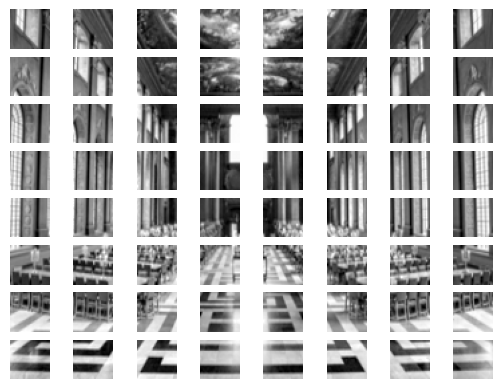

(np.float64(-0.5), np.float64(29.5), np.float64(29.5), np.float64(-0.5))

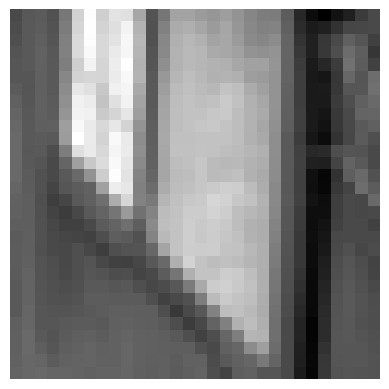

time: 843 ms (started: 2025-01-17 00:40:26 +07:00)


In [18]:
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(lr_images[i], cmap='gray')
    plt.axis('off')
    
plt.show()

plt.imshow(lr_images[0], cmap='gray')
plt.axis('off')

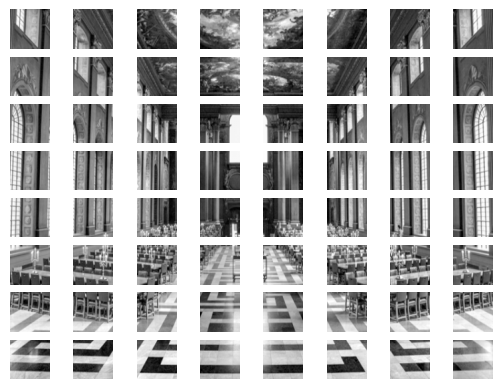

(np.float64(-0.5), np.float64(59.5), np.float64(59.5), np.float64(-0.5))

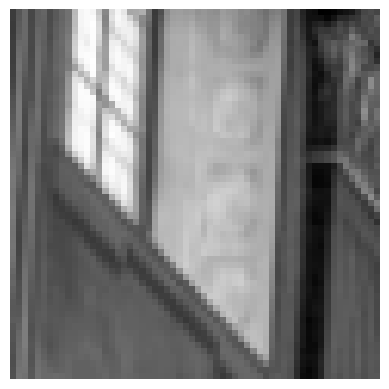

time: 837 ms (started: 2025-01-17 00:40:29 +07:00)


In [19]:
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(hr_images[i], cmap='gray')
    plt.axis('off')
plt.show()

plt.imshow(hr_images[0], cmap='gray')
plt.axis('off')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(lr_images, hr_images, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Shape of Trainset: {X_train.shape}\n\t\t   {y_train.shape}")
print(f"\nShape of Valset: {X_val.shape}\n\t\t {y_val.shape}")
print(f"\nShape of Testset: {X_test.shape}\n\t\t  {y_test.shape}")

print(f"\nNumber Images in Trainset: {int(X_train.shape[0]/64)}")
print(f"\nNumber Images valset: {int(X_val.shape[0]/64)}")
print(f"\nNumber Images testset: {int(X_test.shape[0]/64)}")

Shape of Trainset: (4096, 30, 30)
		   (4096, 60, 60)

Shape of Valset: (1024, 30, 30)
		 (1024, 60, 60)

Shape of Testset: (1280, 30, 30)
		  (1280, 60, 60)

Number Images in Trainset: 64

Number Images valset: 16

Number Images testset: 20
time: 76.2 ms (started: 2025-01-27 10:00:14 +07:00)


# Build Model

## MLP

In [7]:
class Layer:
    def __init__(self):
        self.weights = None
        self.bias = None
        self.activation = None
        self.shape = {
            "input": None,
            "output": None
        }
        self.batch_norm_weights = {
            "epsilon": None,
            "momentum": None,
            "gamma": None,
            "beta": None,
            "running_mean": None,
            "running_var": None
        }
        self.feature_maps = {
            "Z": None,
            "A": None,
            "A_prev": None
        }
        self.gradients = {
            "dA": None,
            "dZ": None,
            "dA_prev": None,
            "dW": None,
            "db": None
        }
        self.def_name = []

    def Input(self, input_shape):
        self.shape['input'] = input_shape
        self.shape['output'] = input_shape
        self.def_name.append("Input")
        return self

    def Flatten(self):
        if self.shape['input'] is None:
            self.shape['output'] = None
        else:
            if len(self.shape['input']) > 2:
                self.shape['output'] = (self.shape['input'][0], np.prod(self.shape['input'][1:]).item())
            else:
                self.shape['output'] = (np.prod(self.shape['input']).item())
        self.def_name.append("Flatten")
        return self

    def BatchNormalization(self, epsilon=1e-5, momentum=0.9):
        if self.shape['input'] is None:
            raise ValueError("Input shape required for BatchNormalization")
        if isinstance(self.shape['input'], int):
            feature_dim = self.shape['input']
        else:
            feature_dim = self.shape['input'][1] if len(self.shape['input']) > 1 else self.shape['input'][0]

        self.shape['output'] = self.shape['input']
        self.batch_norm_weights['epsilon'] = epsilon
        self.batch_norm_weights['momentum'] = momentum
        self.batch_norm_weights['running_mean'] = None
        self.batch_norm_weights['running_var'] = None

        self.batch_norm_weights['running_mean'] = np.zeros(feature_dim) if self.batch_norm_weights['running_mean'] is None else self.batch_norm_weights['running_mean']
        self.batch_norm_weights['running_var'] = np.ones(feature_dim) if self.batch_norm_weights['running_var'] is None else self.batch_norm_weights['running_var']
        self.batch_norm_weights['gamma'] = np.ones(feature_dim)
        self.batch_norm_weights['beta'] = np.zeros(feature_dim)

        self.def_name.append("BatchNormalization")
        return self

    def batch_norm_forward(self, x, training=False):
        if training:
            mean = np.mean(x, axis=0)
            var = np.var(x, axis=0)
            self.batch_norm_weights['running_mean'] = self.batch_norm_weights['momentum'] * self.batch_norm_weights['running_mean'] + (1 - self.batch_norm_weights['momentum']) * mean
            self.batch_norm_weights['running_var'] = self.batch_norm_weights['momentum'] * self.batch_norm_weights['running_var'] + (1 - self.batch_norm_weights['momentum']) * var
        else:
            mean = self.batch_norm_weights['running_mean']
            var = self.batch_norm_weights['running_var']
        x_norm = (x - mean) / np.sqrt(var + self.batch_norm_weights['epsilon'])
        return self.batch_norm_weights['gamma']  * x_norm + self.batch_norm_weights['beta']

    def batch_norm_backward(self, grad_out, x):
        mean = np.mean(x, axis=0)
        var = np.var(x, axis=0)
        N = x.shape[0]
        x_norm = (x - mean) / np.sqrt(var + self.batch_norm_weights['epsilon'])
        dgamma = np.sum(grad_out * x_norm, axis=0)
        dbeta = np.sum(grad_out, axis=0)
        dmean = np.sum(grad_out * -1 / np.sqrt(var + self.batch_norm_weights['epsilon']), axis=0)
        dvar = np.sum(grad_out * (x - mean) * -0.5 * (var + self.batch_norm_weights['epsilon']) ** (-1.5), axis=0)
        dx = grad_out / np.sqrt(var + self.batch_norm_weights['epsilon']) + dmean / N + dvar * 2 * (x - mean) / N
        return dx, dgamma, dbeta

    def Dense(self, input_units, output_units, activation=None):
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.bias = np.zeros((1, output_units))
        self.activation = activation
        self.shape['input'] = input_units
        self.shape['output'] = output_units
        self.def_name.append("Dense")
        self.def_name.append("Activation") if activation is not None else None
        return self

    def Resize(self, output_shape):
        self.shape['output'] = output_shape
        self.def_name.append("Resize")
        return self

    def forward(self, A_prev, training=False, batch=False):
        self.feature_maps['A_prev'] = A_prev
        for i in range(len(self.def_name)):
            if self.def_name[i] == "BatchNormalization":
                self.feature_maps['A'] = self.batch_norm_forward(A_prev, training)
                return self.feature_maps['A']
            elif self.def_name[i] == "Input":
                self.feature_maps['A'] = A_prev
            elif self.def_name[i] == "Flatten":
                if batch:
                    self.feature_maps['A'] = A_prev.reshape(A_prev.shape[0], np.prod(self.shape['output']).item())
                else:
                    self.feature_maps['A'] = A_prev.reshape(np.prod(self.shape['output']).item())
            elif self.def_name[i] == "Resize":
                if batch:
                    self.feature_maps['A'] = A_prev.reshape(A_prev.shape[0], self.shape['output'][0], self.shape['output'][1])
                else:
                    self.feature_maps['A'] = A_prev.reshape(self.shape['output'][0], self.shape['output'][1])
            else:
                self.feature_maps['Z'] = np.dot(A_prev, self.weights) + self.bias
                self.feature_maps['A'] = self.activate(self.feature_maps['Z'])
        return self.feature_maps['A']

    def backward(self, dA, m, learning_rate, batch):
        A_prev = self.feature_maps['A_prev']
        self.gradients['dA'] = dA
        for i in range(len(self.def_name)):
            if self.def_name[i] == "BatchNormalization":
                dZ, dgamma, dbeta = self.batch_norm_backward(dA, A_prev)
                self.batch_norm_weights['gamma'] -= learning_rate * dgamma
                self.batch_norm_weights['beta'] -= learning_rate * dbeta
                self.gradients['dA_prev'] = dZ
            elif self.def_name[i] == "Input":
                self.gradients['dA'] = dA
            elif self.def_name[i] == "Flatten":
                if batch:
                    self.gradients['dA'] = dA.reshape(A_prev.shape[0], self.shape['input'][0], self.shape['input'][1])
                else:
                    self.gradients['dA'] = dA.reshape(self.shape['input'][0], self.shape['input'][1])
                return self.gradients['dA']
            elif self.def_name[i] == "Resize":
                if batch:
                    self.gradients['dA'] = dA.reshape(A_prev.shape[0], np.prod(self.shape['input']).item())
                else:
                    self.gradients['dA'] = dA.reshape(np.prod(self.shape['input']).item())
                return self.gradients['dA']
            elif self.def_name[i] == "Dense":
                self.gradients['dZ'] = self.gradients['dA'] * self.activate_derivative(self.feature_maps['Z'])
                self.gradients['dW'] = np.dot(A_prev.T, self.gradients['dZ']) / m
                self.gradients['db'] = np.sum(self.gradients['dZ'], axis=0, keepdims=True) / m
                self.gradients['dA_prev'] = np.dot(self.gradients['dZ'], self.weights.T)
        return self.gradients['dA_prev']

    def update_parameters(self, learning_rate):
        if self.weights is None or self.bias is None:
            return
        self.weights -= learning_rate * self.gradients['dW']
        self.bias -= learning_rate * self.gradients['db']

    def activate(self, Z):
        if self.activation == "relu":
            return np.maximum(0, Z)
        elif self.activation == "sigmoid":
            return 1 / (1 + np.exp(-Z))
        elif self.activation == "softmax":
            expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
            return expZ / np.sum(expZ, axis=1, keepdims=True)
        elif self.activation == "tanh":
            return np.tanh(Z)
        elif self.activation is None:
            return Z
        else:
            raise ValueError(f"Unsupported activation '{self.activation}'.")

    def activate_derivative(self, Z):
        if self.activation == "relu":
            return (Z > 0).astype(float)
        elif self.activation == "sigmoid":
            A = 1 / (1 + np.exp(-Z))
            return A * (1 - A)
        elif self.activation == "softmax":
            A = self.activate(Z)
            return A * (1 - A)
        elif self.activation == "tanh":
            return 1 - np.tanh(Z) ** 2
        elif self.activation is None:
            return np.ones_like(Z)
        else:
            raise ValueError(f"Unsupported activation '{self.activation}'.")

    def set_parameters(self, diction):
        self.weights = diction["weights"]
        self.bias = diction["bias"]
        self.activation = diction["activation"]
        self.shape = diction["shape"]
        self.batch_norm_weights = diction["batch_norm_weights"]
        self.feature_maps = diction["feature_maps"]
        self.gradients = diction["gradients"]
        self.def_name = diction["def_name"]

    def get_parameters(self):
        return {
            "weights": self.weights,
            "bias": self.bias,
            "activation": self.activation,
            "shape": self.shape,
            "batch_norm_weights": self.batch_norm_weights,
            "feature_maps": self.feature_maps,
            "gradients": self.gradients,
            "def_name": self.def_name
        }

time: 4.34 ms (started: 2025-01-27 09:59:23 +07:00)


In [8]:
class MLP:
    def __init__(self):
        self.layers = []
        self.current_shape = None
        self.is_training = False
        self.batch = False
        self.optimizer = {
            'loss_fn': None,
            'metrics': None
        }
        self.best_weights = None
        self.continue_training = False
        self.current_lr = None
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_metric": [],
            "val_metric": []
        }

    def add(self, layer):
        self.current_shape = layer.shape["output"]
        self.layers.append(layer)

    def forward(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A, self.is_training, self.batch)
        return A

    def backward(self, output, Y, learning_rate):
        m = Y.shape[0]
        dA = self._calculate_gradient(output, Y, grad_fn=self.optimizer['loss_fn'].__name__)
        for layer in reversed(self.layers):
            dA = layer.backward(dA, m, learning_rate, self.batch)
            layer.update_parameters(learning_rate)

    def train(self, X_train, Y_train, epochs, learning_rate, batch_size=32, X_val=None, Y_val=None, early_stopping_rounds=7, lr_patience=3, lr_factor=0.2):
        self.is_training = True
        self.batch = True if len(X_train.shape) > 2 else False
        best_val_loss = float('inf')
        no_improvement_rounds = 0
        current_lr = self.current_lr if self.continue_training else learning_rate
        self.history["train_loss"] = self.history["train_loss"] if self.continue_training else []
        self.history["val_loss"] = self.history["val_loss"] if self.continue_training else []
        self.history["train_metric"] = self.history["train_metric"] if self.continue_training else {}
        self.history["val_metric"] = self.history["val_metric"] if self.continue_training else {}

        # Initialize history for each metric
        for metric in self.optimizer['metrics']:
            self.history["train_metric"][metric.__name__] = self.history["train_metric"].get(metric.__name__, [])
            self.history["val_metric"][metric.__name__] = self.history["val_metric"].get(metric.__name__, [])

        loss_func = self.optimizer['loss_fn']
        metric_funcs = self.optimizer['metrics']

        for epoch in range(epochs):
            progress_bar = tqdm(range(X_train.shape[0] // batch_size), desc=f"Epoch {epoch + 1}/{epochs}", unit="step")

            epoch_loss = 0
            epoch_metrics = {metric.__name__: 0 for metric in metric_funcs}

            for step in progress_bar:
                start = step * batch_size
                end = start + batch_size
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                output = self.forward(X_batch)

                loss = loss_func(output, Y_batch)
                epoch_loss += loss

                for metric in metric_funcs:
                    epoch_metrics[metric.__name__] += metric(output, Y_batch)

                self.backward(output, Y_batch, current_lr)

                progress_bar.set_postfix(
                    loss=epoch_loss / (step + 1),
                    **{name: epoch_metrics[name] / (step + 1) for name in epoch_metrics}
                )

            train_loss = epoch_loss / (X_train.shape[0] // batch_size)
            train_metrics = {name: epoch_metrics[name] / (X_train.shape[0] // batch_size) for name in epoch_metrics}

            self.history["train_loss"].append(train_loss)
            for name, value in train_metrics.items():
                self.history["train_metric"][name].append(value)

            if X_val is not None and Y_val is not None:
                val_output = self.forward(X_val)
                val_loss = loss_func(val_output, Y_val)

                val_metrics = {metric.__name__: metric(val_output, Y_val) for metric in metric_funcs}

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_rounds = 0
                    self.best_weights = [layer.get_parameters() for layer in self.layers]
                else:
                    no_improvement_rounds += 1

                if early_stopping_rounds and no_improvement_rounds >= early_stopping_rounds:
                    print(f"Early stopping at epoch {epoch + 1}")
                    self.set_weights(self.best_weights)
                    self.is_training = False
                    break

                if no_improvement_rounds >= lr_patience:
                    print(f"Reducing learning rate by factor of {lr_factor}")
                    current_lr *= lr_factor
                    self.current_lr = current_lr

                self.history["val_loss"].append(val_loss)
                for name, value in val_metrics.items():
                    self.history["val_metric"][name].append(value)

                val_metric_str = " - ".join([f"val_{name}: {value:.4f}" for name, value in val_metrics.items()])
                print(f"Epoch {epoch + 1}/{epochs} - loss: {train_loss:.4f} - " +
                      " - ".join([f"{name}: {value:.4f}" for name, value in train_metrics.items()]) +
                      f" - val_loss: {val_loss:.4f} - {val_metric_str}")
            else:
                print(f"Epoch {epoch + 1}/{epochs} - loss: {train_loss:.4f} - " +
                      " - ".join([f"{name}: {value:.4f}" for name, value in train_metrics.items()]))

        self.current_lr = current_lr
        self.is_training = False

    def predict(self, X):
        return self.forward(X)

    def evaluate(self, X, Y):
        self.batch = True if len(X.shape) > 2 else False
        output = self.forward(X)
        loss = self.optimizer['loss_fn'](output, Y)
        metric_value = {}
        for metric in self.optimizer['metrics']:
            metric_value[metric.__name__] = metric(output, Y)
        return loss, metric_value

    def compile(self, loss, metrics=None):
        """
        Phương thức compile để thiết lập loss và metrics cho mô hình.
        """
        self.optimizer['loss_fn'] = loss
        self.optimizer['metrics'] = metrics if metrics else []

    def get_weights(self):
        return [layer.get_parameters() for layer in self.layers]

    def set_weights(self, parameters):
        for layer, params in zip(self.layers, parameters):
            layer.set_parameters(params)

    def get_model(self):
        weights = self.get_weights()
        parameters = {
            "weights": weights,
            "optimizer": self.optimizer,
            "history": self.history,
            "current_lr": self.current_lr
        }
        return parameters

    def load_model(self, parameters):
        for weights in parameters["weights"]:
            layer = Layer()
            layer.set_parameters(weights)
            self.add(layer)
        self.optimizer = parameters["optimizer"]
        self.history = parameters["history"]
        self.current_lr = parameters["current_lr"]

    def summary(self):
        """
        In ra tóm tắt về cấu trúc mô hình: tên lớp, kích thước đầu vào, đầu ra, số tham số.
        """
        total_params = 0
        print("Model Summary:")
        print("="*50)

        for i, layer in enumerate(self.layers):
            layer_name = layer.__class__.__name__
            for name in layer.def_name:
                layer_name += f" -> {name}"
            print(f"Layer {i+1}: {layer_name}")

            input_shape = layer.shape['input'] if layer.shape['input'] else 'None'
            output_shape = layer.shape['output'] if layer.shape['output'] else 'None'
            print(f"  Input Shape: {input_shape}")
            print(f"  Output Shape: {output_shape}")

            num_params = 0
            if hasattr(layer, 'weights') and layer.weights is not None:
                num_params += np.prod(layer.weights.shape)
            if hasattr(layer, 'bias') and layer.bias is not None:
                num_params += np.prod(layer.bias.shape)
            if hasattr(layer, 'batch_norm_weights'):
                if 'gamma' in layer.batch_norm_weights and layer.batch_norm_weights['gamma'] is not None:
                    num_params += np.prod(layer.batch_norm_weights['gamma'].shape)
                if 'beta' in layer.batch_norm_weights and layer.batch_norm_weights['beta'] is not None:
                    num_params += np.prod(layer.batch_norm_weights['beta'].shape)

            total_params += num_params
            print(f"  Number of Parameters: {num_params}")
            print("-"*50)

        print(f"Total Parameters: {total_params}")
        print("="*50)

    def _calculate_gradient(self, predicted, target, grad_fn):
        """
        Tính toán gradient của loss function đối với đầu ra dự đoán.
        """

        def __mse_loss_grad(predicted, target):
            return 2 * (predicted - target) / predicted.shape[0]

        def __ssim_loss_grad(predicted, target):
            """
            Tính toán gradient của SSIM đối với đầu ra dự đoán.
            """
            C1 = 0.01 ** 2
            C2 = 0.03 ** 2

            mu_X = predicted.mean()
            mu_Y = target.mean()
            mu_XY = mu_X * mu_X

            # sigma_X = ((predicted - mu_X) ** 2).mean()
            # sigma_Y = ((target - mu_Y) ** 2).mean()

            sigma_X = np.var(predicted)
            sigma_Y = np.var(target)

            sigma_XY = ((predicted - mu_X) * (target - mu_Y)).mean()

            # d_ssim_d_pred = (
            #     (2 * mu_Y + C1) * (2 * sigma_XY + C2) - (2 * predicted + 2 * mu_X) * (sigma_X + sigma_Y + C2)
            # ) / ((mu_X ** 2 + mu_Y ** 2 + C1) ** 2)

            N = predicted.shape[0]

            # Đạo hàm của các giá trị trung gian
            d_mu_X = 1 / N
            d_sigma_X = 2 * (predicted - mu_X) / N
            d_sigma_XY = (target - mu_Y) / N

            # Đạo hàm của SSIM với các giá trị trung gian
            d_ssim_d_mu_X = 2 * ((2 * mu_XY + C1) * (2 * sigma_XY + C2) * mu_X -
                                (mu_X ** 2 + mu_Y ** 2 + C1) * (sigma_X ** 2 + sigma_Y ** 2 + C2)) / (
                (mu_X ** 2 + mu_Y ** 2 + C1) ** 2 * (sigma_X ** 2 + sigma_Y ** 2 + C2))

            d_ssim_d_sigma_X = -((2 * mu_XY + C1) * (2 * sigma_XY + C2)) / (
                (mu_X ** 2 + mu_Y ** 2 + C1) * (sigma_X + sigma_Y + C2) ** 2)

            d_ssim_d_sigma_XY = (2 * (2 * mu_XY + C1)) / (
                (mu_X ** 2 + mu_Y ** 2 + C1) * (sigma_X ** 2 + sigma_Y ** 2 + C2))

            # ssim_grad = -d_ssim_d_pred / predicted.shape[0]
            # return ssim_grad

            grad = (d_ssim_d_mu_X * d_mu_X +
                    d_ssim_d_sigma_X * d_sigma_X +
                    d_ssim_d_sigma_XY * d_sigma_XY)

            # Gradient của loss
            grad_loss = -grad  # Do loss = 1 - SSIM
            return grad_loss

        def __combined_loss_grad(x, y):
            alpha = 0.05
            ssim_grad = __ssim_loss_grad(x, y)
            mse_grad = __mse_loss_grad(x, y)

            norm_ssim_grad = ssim_grad / (np.linalg.norm(ssim_grad) + 1e-8)
            norm_mse_grad = mse_grad / (np.linalg.norm(mse_grad) + 1e-8)

            return alpha * norm_ssim_grad  + (1 - alpha) * norm_mse_grad

        def __psnr_loss_grad(predicted, target):
            mse = ((predicted - target) ** 2).mean()
            mse_grad = __mse_loss_grad(predicted, target)
            psnr_grad = - 10 / (np.log(10) * mse)
            psnr_loss_grad = - psnr_grad * mse_grad
            return psnr_loss_grad

        if grad_fn == 'mse_loss':
            return __mse_loss_grad(predicted, target)
        elif grad_fn == 'ssim_loss':
            return __ssim_loss_grad(predicted, target)
        elif grad_fn == 'combined_loss':
            return __combined_loss_grad(predicted, target)
        elif grad_fn == 'psnr_loss':
            return __psnr_loss_grad(predicted, target)

time: 5.84 ms (started: 2025-01-27 09:59:28 +07:00)


In [9]:
def mse_loss(predicted, target):
    return ((predicted - target) ** 2).mean()

# def ssim_metric(predicted, target):

#     max_value = 1.0

#     C1 = (0.01 * max_value)** 2
#     C2 = (0.03 * max_value) ** 2

#     mu_x = np.mean(predicted)
#     mu_y = np.mean(target)

#     sigma_x = np.mean((predicted - mu_x) ** 2)
#     sigma_y = np.mean((target - mu_y) ** 2)
#     sigma_xy = np.mean((predicted - mu_x) * (target - mu_y))

#     numerator = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
#     denominator = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x ** 2 + sigma_y ** 2 + C2)

#     ssim = numerator / denominator
#     # ssim = max(0, min(1, ssim))
#     return ssim

def ssim_metric(predicted, target):
    predicted = tf.convert_to_tensor(predicted, dtype=tf.float32)
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    ssim = tf.image.ssim(predicted, target, max_val=1.0)
    return ssim.numpy()

# def ssim_loss(predicted, target):
#     return 1 - ssim_metric(predicted, target)

# def combined_loss(predicted, target):
#     alpha = 0.05
#     return alpha * ssim_loss(predicted, target) + (1 - alpha) * mse_loss(predicted, target)

def psnr_metric(predicted, target, max_val=1.0):
    mse = mse_loss(predicted, target)
    if(mse == 0):
        return 100
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

time: 633 μs (started: 2025-01-27 09:59:34 +07:00)


In [26]:
model = MLP()

hidden_units = [1024, 2048, 4096]

model.add(Layer().Input((patch_size, patch_size)).Flatten())

for units in hidden_units:
    model.add(Layer().Dense(model.current_shape, units, activation="relu"))
    model.add(Layer().Input(model.current_shape).BatchNormalization())

model.add(Layer().Dense(model.current_shape, patch_size*2*patch_size*2))
model.add(Layer().Input(model.current_shape).Resize((patch_size*2, patch_size*2)))

model.compile(loss=mse_loss, metrics=[psnr_metric, ssim_metric])

model.summary()

Model Summary:
Layer 1: Layer -> Input -> Flatten
  Input Shape: (30, 30)
  Output Shape: 900
  Number of Parameters: 0
--------------------------------------------------
Layer 2: Layer -> Dense -> Activation
  Input Shape: 900
  Output Shape: 1024
  Number of Parameters: 922624
--------------------------------------------------
Layer 3: Layer -> Input -> BatchNormalization
  Input Shape: 1024
  Output Shape: 1024
  Number of Parameters: 2048
--------------------------------------------------
Layer 4: Layer -> Dense -> Activation
  Input Shape: 1024
  Output Shape: 2048
  Number of Parameters: 2099200
--------------------------------------------------
Layer 5: Layer -> Input -> BatchNormalization
  Input Shape: 2048
  Output Shape: 2048
  Number of Parameters: 4096
--------------------------------------------------
Layer 6: Layer -> Dense -> Activation
  Input Shape: 2048
  Output Shape: 4096
  Number of Parameters: 8392704
--------------------------------------------------
Layer 7: La

In [10]:
with open('model_params_mse_loss.pkl', 'rb') as f:
    loaded_params = dill.load(f)
    
model = MLP()
model.load_model(loaded_params)

time: 2.36 s (started: 2025-01-27 09:59:50 +07:00)


In [11]:
model.current_lr

0.005

time: 2.92 ms (started: 2025-01-27 09:59:54 +07:00)


In [41]:
model.continue_training = True

time: 301 μs (started: 2025-01-17 02:30:34 +07:00)


In [42]:
model.train(X_train, y_train, epochs=200, learning_rate=0.005, batch_size=64, X_val=X_val, Y_val=y_val, early_stopping_rounds=10, lr_patience=5, lr_factor=0.25)

Epoch 1/200: 100%|██████████| 64/64 [00:46<00:00,  1.38step/s, loss=0.0102, psnr_metric=19.9, ssim_metric=0.892] 


Epoch 1/200 - loss: 0.0102 - psnr_metric: 19.9456 - ssim_metric: 0.8921 - val_loss: 0.0119 - val_psnr_metric: 19.2428 - val_ssim_metric: 0.8663


Epoch 2/200: 100%|██████████| 64/64 [00:41<00:00,  1.54step/s, loss=0.0102, psnr_metric=20, ssim_metric=0.892]   


Epoch 2/200 - loss: 0.0102 - psnr_metric: 19.9519 - ssim_metric: 0.8922 - val_loss: 0.0119 - val_psnr_metric: 19.2469 - val_ssim_metric: 0.8664


Epoch 3/200: 100%|██████████| 64/64 [00:26<00:00,  2.44step/s, loss=0.0102, psnr_metric=20, ssim_metric=0.892]   


Epoch 3/200 - loss: 0.0102 - psnr_metric: 19.9582 - ssim_metric: 0.8924 - val_loss: 0.0119 - val_psnr_metric: 19.2508 - val_ssim_metric: 0.8665


Epoch 4/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.0102, psnr_metric=20, ssim_metric=0.893]   


Epoch 4/200 - loss: 0.0102 - psnr_metric: 19.9644 - ssim_metric: 0.8926 - val_loss: 0.0119 - val_psnr_metric: 19.2548 - val_ssim_metric: 0.8667


Epoch 5/200: 100%|██████████| 64/64 [00:20<00:00,  3.05step/s, loss=0.0102, psnr_metric=20, ssim_metric=0.893]   


Epoch 5/200 - loss: 0.0102 - psnr_metric: 19.9707 - ssim_metric: 0.8927 - val_loss: 0.0119 - val_psnr_metric: 19.2588 - val_ssim_metric: 0.8668


Epoch 6/200: 100%|██████████| 64/64 [00:22<00:00,  2.83step/s, loss=0.0101, psnr_metric=20, ssim_metric=0.893]   


Epoch 6/200 - loss: 0.0101 - psnr_metric: 19.9770 - ssim_metric: 0.8929 - val_loss: 0.0119 - val_psnr_metric: 19.2627 - val_ssim_metric: 0.8669


Epoch 7/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.0101, psnr_metric=20, ssim_metric=0.893]   


Epoch 7/200 - loss: 0.0101 - psnr_metric: 19.9832 - ssim_metric: 0.8931 - val_loss: 0.0118 - val_psnr_metric: 19.2666 - val_ssim_metric: 0.8671


Epoch 8/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.0101, psnr_metric=20, ssim_metric=0.893]   


Epoch 8/200 - loss: 0.0101 - psnr_metric: 19.9894 - ssim_metric: 0.8932 - val_loss: 0.0118 - val_psnr_metric: 19.2706 - val_ssim_metric: 0.8672


Epoch 9/200: 100%|██████████| 64/64 [00:21<00:00,  2.96step/s, loss=0.0101, psnr_metric=20, ssim_metric=0.893]   


Epoch 9/200 - loss: 0.0101 - psnr_metric: 19.9956 - ssim_metric: 0.8934 - val_loss: 0.0118 - val_psnr_metric: 19.2745 - val_ssim_metric: 0.8673


Epoch 10/200: 100%|██████████| 64/64 [00:26<00:00,  2.41step/s, loss=0.0101, psnr_metric=20, ssim_metric=0.894]   


Epoch 10/200 - loss: 0.0101 - psnr_metric: 20.0018 - ssim_metric: 0.8936 - val_loss: 0.0118 - val_psnr_metric: 19.2784 - val_ssim_metric: 0.8674


Epoch 11/200: 100%|██████████| 64/64 [00:22<00:00,  2.83step/s, loss=0.0101, psnr_metric=20, ssim_metric=0.894]   


Epoch 11/200 - loss: 0.0101 - psnr_metric: 20.0079 - ssim_metric: 0.8937 - val_loss: 0.0118 - val_psnr_metric: 19.2822 - val_ssim_metric: 0.8676


Epoch 12/200: 100%|██████████| 64/64 [00:22<00:00,  2.85step/s, loss=0.0101, psnr_metric=20, ssim_metric=0.894]   


Epoch 12/200 - loss: 0.0101 - psnr_metric: 20.0141 - ssim_metric: 0.8939 - val_loss: 0.0118 - val_psnr_metric: 19.2861 - val_ssim_metric: 0.8677


Epoch 13/200: 100%|██████████| 64/64 [00:48<00:00,  1.33step/s, loss=0.01, psnr_metric=20, ssim_metric=0.894]     


Epoch 13/200 - loss: 0.0100 - psnr_metric: 20.0202 - ssim_metric: 0.8940 - val_loss: 0.0118 - val_psnr_metric: 19.2900 - val_ssim_metric: 0.8678


Epoch 14/200: 100%|██████████| 64/64 [00:45<00:00,  1.40step/s, loss=0.01, psnr_metric=20, ssim_metric=0.894]     


Epoch 14/200 - loss: 0.0100 - psnr_metric: 20.0263 - ssim_metric: 0.8942 - val_loss: 0.0118 - val_psnr_metric: 19.2938 - val_ssim_metric: 0.8679


Epoch 15/200: 100%|██████████| 64/64 [00:44<00:00,  1.45step/s, loss=0.01, psnr_metric=20, ssim_metric=0.894]     


Epoch 15/200 - loss: 0.0100 - psnr_metric: 20.0324 - ssim_metric: 0.8944 - val_loss: 0.0118 - val_psnr_metric: 19.2975 - val_ssim_metric: 0.8681


Epoch 16/200: 100%|██████████| 64/64 [00:44<00:00,  1.43step/s, loss=0.00999, psnr_metric=20, ssim_metric=0.895]  


Epoch 16/200 - loss: 0.0100 - psnr_metric: 20.0385 - ssim_metric: 0.8945 - val_loss: 0.0117 - val_psnr_metric: 19.3013 - val_ssim_metric: 0.8682


Epoch 17/200: 100%|██████████| 64/64 [00:44<00:00,  1.44step/s, loss=0.00998, psnr_metric=20, ssim_metric=0.895]  


Epoch 17/200 - loss: 0.0100 - psnr_metric: 20.0446 - ssim_metric: 0.8947 - val_loss: 0.0117 - val_psnr_metric: 19.3050 - val_ssim_metric: 0.8683


Epoch 18/200: 100%|██████████| 64/64 [00:46<00:00,  1.38step/s, loss=0.00997, psnr_metric=20.1, ssim_metric=0.895]


Epoch 18/200 - loss: 0.0100 - psnr_metric: 20.0506 - ssim_metric: 0.8949 - val_loss: 0.0117 - val_psnr_metric: 19.3089 - val_ssim_metric: 0.8684


Epoch 19/200: 100%|██████████| 64/64 [00:44<00:00,  1.43step/s, loss=0.00995, psnr_metric=20.1, ssim_metric=0.895]


Epoch 19/200 - loss: 0.0100 - psnr_metric: 20.0566 - ssim_metric: 0.8950 - val_loss: 0.0117 - val_psnr_metric: 19.3125 - val_ssim_metric: 0.8686


Epoch 20/200: 100%|██████████| 64/64 [00:43<00:00,  1.46step/s, loss=0.00994, psnr_metric=20.1, ssim_metric=0.895]


Epoch 20/200 - loss: 0.0099 - psnr_metric: 20.0627 - ssim_metric: 0.8952 - val_loss: 0.0117 - val_psnr_metric: 19.3163 - val_ssim_metric: 0.8687


Epoch 21/200: 100%|██████████| 64/64 [00:44<00:00,  1.45step/s, loss=0.00993, psnr_metric=20.1, ssim_metric=0.895]


Epoch 21/200 - loss: 0.0099 - psnr_metric: 20.0687 - ssim_metric: 0.8953 - val_loss: 0.0117 - val_psnr_metric: 19.3200 - val_ssim_metric: 0.8688


Epoch 22/200: 100%|██████████| 64/64 [00:43<00:00,  1.46step/s, loss=0.00991, psnr_metric=20.1, ssim_metric=0.895]


Epoch 22/200 - loss: 0.0099 - psnr_metric: 20.0747 - ssim_metric: 0.8955 - val_loss: 0.0117 - val_psnr_metric: 19.3236 - val_ssim_metric: 0.8689


Epoch 23/200: 100%|██████████| 64/64 [00:45<00:00,  1.40step/s, loss=0.0099, psnr_metric=20.1, ssim_metric=0.896] 


Epoch 23/200 - loss: 0.0099 - psnr_metric: 20.0806 - ssim_metric: 0.8956 - val_loss: 0.0117 - val_psnr_metric: 19.3273 - val_ssim_metric: 0.8690


Epoch 24/200: 100%|██████████| 64/64 [00:44<00:00,  1.45step/s, loss=0.00988, psnr_metric=20.1, ssim_metric=0.896]


Epoch 24/200 - loss: 0.0099 - psnr_metric: 20.0866 - ssim_metric: 0.8958 - val_loss: 0.0117 - val_psnr_metric: 19.3310 - val_ssim_metric: 0.8692


Epoch 25/200: 100%|██████████| 64/64 [00:43<00:00,  1.47step/s, loss=0.00987, psnr_metric=20.1, ssim_metric=0.896]


Epoch 25/200 - loss: 0.0099 - psnr_metric: 20.0925 - ssim_metric: 0.8960 - val_loss: 0.0117 - val_psnr_metric: 19.3347 - val_ssim_metric: 0.8693


Epoch 26/200: 100%|██████████| 64/64 [00:43<00:00,  1.48step/s, loss=0.00986, psnr_metric=20.1, ssim_metric=0.896]


Epoch 26/200 - loss: 0.0099 - psnr_metric: 20.0985 - ssim_metric: 0.8961 - val_loss: 0.0116 - val_psnr_metric: 19.3384 - val_ssim_metric: 0.8694


Epoch 27/200: 100%|██████████| 64/64 [00:43<00:00,  1.46step/s, loss=0.00984, psnr_metric=20.1, ssim_metric=0.896]


Epoch 27/200 - loss: 0.0098 - psnr_metric: 20.1044 - ssim_metric: 0.8963 - val_loss: 0.0116 - val_psnr_metric: 19.3420 - val_ssim_metric: 0.8695


Epoch 28/200: 100%|██████████| 64/64 [00:42<00:00,  1.50step/s, loss=0.00983, psnr_metric=20.1, ssim_metric=0.896]


Epoch 28/200 - loss: 0.0098 - psnr_metric: 20.1103 - ssim_metric: 0.8964 - val_loss: 0.0116 - val_psnr_metric: 19.3456 - val_ssim_metric: 0.8696


Epoch 29/200: 100%|██████████| 64/64 [00:44<00:00,  1.44step/s, loss=0.00982, psnr_metric=20.1, ssim_metric=0.897]


Epoch 29/200 - loss: 0.0098 - psnr_metric: 20.1162 - ssim_metric: 0.8966 - val_loss: 0.0116 - val_psnr_metric: 19.3492 - val_ssim_metric: 0.8698


Epoch 30/200: 100%|██████████| 64/64 [00:43<00:00,  1.46step/s, loss=0.0098, psnr_metric=20.1, ssim_metric=0.897] 


Epoch 30/200 - loss: 0.0098 - psnr_metric: 20.1221 - ssim_metric: 0.8967 - val_loss: 0.0116 - val_psnr_metric: 19.3528 - val_ssim_metric: 0.8699


Epoch 31/200: 100%|██████████| 64/64 [00:45<00:00,  1.42step/s, loss=0.00979, psnr_metric=20.1, ssim_metric=0.897]


Epoch 31/200 - loss: 0.0098 - psnr_metric: 20.1279 - ssim_metric: 0.8969 - val_loss: 0.0116 - val_psnr_metric: 19.3564 - val_ssim_metric: 0.8700


Epoch 32/200: 100%|██████████| 64/64 [00:44<00:00,  1.43step/s, loss=0.00978, psnr_metric=20.1, ssim_metric=0.897]


Epoch 32/200 - loss: 0.0098 - psnr_metric: 20.1338 - ssim_metric: 0.8970 - val_loss: 0.0116 - val_psnr_metric: 19.3600 - val_ssim_metric: 0.8701


Epoch 33/200: 100%|██████████| 64/64 [00:45<00:00,  1.40step/s, loss=0.00976, psnr_metric=20.1, ssim_metric=0.897]


Epoch 33/200 - loss: 0.0098 - psnr_metric: 20.1396 - ssim_metric: 0.8972 - val_loss: 0.0116 - val_psnr_metric: 19.3635 - val_ssim_metric: 0.8702


Epoch 34/200: 100%|██████████| 64/64 [00:44<00:00,  1.43step/s, loss=0.00975, psnr_metric=20.1, ssim_metric=0.897]


Epoch 34/200 - loss: 0.0098 - psnr_metric: 20.1454 - ssim_metric: 0.8973 - val_loss: 0.0116 - val_psnr_metric: 19.3671 - val_ssim_metric: 0.8703


Epoch 35/200: 100%|██████████| 64/64 [00:46<00:00,  1.37step/s, loss=0.00974, psnr_metric=20.2, ssim_metric=0.897]


Epoch 35/200 - loss: 0.0097 - psnr_metric: 20.1512 - ssim_metric: 0.8975 - val_loss: 0.0116 - val_psnr_metric: 19.3706 - val_ssim_metric: 0.8705


Epoch 36/200: 100%|██████████| 64/64 [00:43<00:00,  1.48step/s, loss=0.00973, psnr_metric=20.2, ssim_metric=0.898]


Epoch 36/200 - loss: 0.0097 - psnr_metric: 20.1570 - ssim_metric: 0.8976 - val_loss: 0.0116 - val_psnr_metric: 19.3742 - val_ssim_metric: 0.8706


Epoch 37/200: 100%|██████████| 64/64 [00:42<00:00,  1.49step/s, loss=0.00971, psnr_metric=20.2, ssim_metric=0.898]


Epoch 37/200 - loss: 0.0097 - psnr_metric: 20.1628 - ssim_metric: 0.8978 - val_loss: 0.0115 - val_psnr_metric: 19.3776 - val_ssim_metric: 0.8707


Epoch 38/200: 100%|██████████| 64/64 [00:42<00:00,  1.51step/s, loss=0.0097, psnr_metric=20.2, ssim_metric=0.898] 


Epoch 38/200 - loss: 0.0097 - psnr_metric: 20.1685 - ssim_metric: 0.8979 - val_loss: 0.0115 - val_psnr_metric: 19.3812 - val_ssim_metric: 0.8708


Epoch 39/200: 100%|██████████| 64/64 [00:43<00:00,  1.47step/s, loss=0.00969, psnr_metric=20.2, ssim_metric=0.898]


Epoch 39/200 - loss: 0.0097 - psnr_metric: 20.1743 - ssim_metric: 0.8981 - val_loss: 0.0115 - val_psnr_metric: 19.3846 - val_ssim_metric: 0.8709


Epoch 40/200: 100%|██████████| 64/64 [00:24<00:00,  2.62step/s, loss=0.00967, psnr_metric=20.2, ssim_metric=0.898]


Epoch 40/200 - loss: 0.0097 - psnr_metric: 20.1800 - ssim_metric: 0.8982 - val_loss: 0.0115 - val_psnr_metric: 19.3881 - val_ssim_metric: 0.8710


Epoch 41/200: 100%|██████████| 64/64 [00:24<00:00,  2.65step/s, loss=0.00966, psnr_metric=20.2, ssim_metric=0.898]


Epoch 41/200 - loss: 0.0097 - psnr_metric: 20.1857 - ssim_metric: 0.8984 - val_loss: 0.0115 - val_psnr_metric: 19.3915 - val_ssim_metric: 0.8711


Epoch 42/200: 100%|██████████| 64/64 [00:24<00:00,  2.62step/s, loss=0.00965, psnr_metric=20.2, ssim_metric=0.899]


Epoch 42/200 - loss: 0.0096 - psnr_metric: 20.1914 - ssim_metric: 0.8985 - val_loss: 0.0115 - val_psnr_metric: 19.3949 - val_ssim_metric: 0.8712


Epoch 43/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00964, psnr_metric=20.2, ssim_metric=0.899]


Epoch 43/200 - loss: 0.0096 - psnr_metric: 20.1971 - ssim_metric: 0.8986 - val_loss: 0.0115 - val_psnr_metric: 19.3983 - val_ssim_metric: 0.8714


Epoch 44/200: 100%|██████████| 64/64 [00:24<00:00,  2.60step/s, loss=0.00962, psnr_metric=20.2, ssim_metric=0.899]


Epoch 44/200 - loss: 0.0096 - psnr_metric: 20.2028 - ssim_metric: 0.8988 - val_loss: 0.0115 - val_psnr_metric: 19.4018 - val_ssim_metric: 0.8715


Epoch 45/200: 100%|██████████| 64/64 [00:24<00:00,  2.61step/s, loss=0.00961, psnr_metric=20.2, ssim_metric=0.899]


Epoch 45/200 - loss: 0.0096 - psnr_metric: 20.2084 - ssim_metric: 0.8989 - val_loss: 0.0115 - val_psnr_metric: 19.4051 - val_ssim_metric: 0.8716


Epoch 46/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.0096, psnr_metric=20.2, ssim_metric=0.899] 


Epoch 46/200 - loss: 0.0096 - psnr_metric: 20.2141 - ssim_metric: 0.8991 - val_loss: 0.0115 - val_psnr_metric: 19.4085 - val_ssim_metric: 0.8717


Epoch 47/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00959, psnr_metric=20.2, ssim_metric=0.899]


Epoch 47/200 - loss: 0.0096 - psnr_metric: 20.2197 - ssim_metric: 0.8992 - val_loss: 0.0115 - val_psnr_metric: 19.4119 - val_ssim_metric: 0.8718


Epoch 48/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00957, psnr_metric=20.2, ssim_metric=0.899]


Epoch 48/200 - loss: 0.0096 - psnr_metric: 20.2253 - ssim_metric: 0.8994 - val_loss: 0.0114 - val_psnr_metric: 19.4153 - val_ssim_metric: 0.8719


Epoch 49/200: 100%|██████████| 64/64 [00:24<00:00,  2.66step/s, loss=0.00956, psnr_metric=20.2, ssim_metric=0.9]  


Epoch 49/200 - loss: 0.0096 - psnr_metric: 20.2309 - ssim_metric: 0.8995 - val_loss: 0.0114 - val_psnr_metric: 19.4187 - val_ssim_metric: 0.8720


Epoch 50/200: 100%|██████████| 64/64 [00:24<00:00,  2.64step/s, loss=0.00955, psnr_metric=20.2, ssim_metric=0.9]  


Epoch 50/200 - loss: 0.0095 - psnr_metric: 20.2365 - ssim_metric: 0.8996 - val_loss: 0.0114 - val_psnr_metric: 19.4220 - val_ssim_metric: 0.8721


Epoch 51/200: 100%|██████████| 64/64 [00:23<00:00,  2.70step/s, loss=0.00954, psnr_metric=20.2, ssim_metric=0.9]  


Epoch 51/200 - loss: 0.0095 - psnr_metric: 20.2421 - ssim_metric: 0.8998 - val_loss: 0.0114 - val_psnr_metric: 19.4254 - val_ssim_metric: 0.8722


Epoch 52/200: 100%|██████████| 64/64 [00:23<00:00,  2.71step/s, loss=0.00952, psnr_metric=20.2, ssim_metric=0.9]  


Epoch 52/200 - loss: 0.0095 - psnr_metric: 20.2476 - ssim_metric: 0.8999 - val_loss: 0.0114 - val_psnr_metric: 19.4287 - val_ssim_metric: 0.8723


Epoch 53/200: 100%|██████████| 64/64 [00:22<00:00,  2.82step/s, loss=0.00951, psnr_metric=20.3, ssim_metric=0.9]  


Epoch 53/200 - loss: 0.0095 - psnr_metric: 20.2532 - ssim_metric: 0.9001 - val_loss: 0.0114 - val_psnr_metric: 19.4320 - val_ssim_metric: 0.8724


Epoch 54/200: 100%|██████████| 64/64 [00:24<00:00,  2.66step/s, loss=0.0095, psnr_metric=20.3, ssim_metric=0.9]   


Epoch 54/200 - loss: 0.0095 - psnr_metric: 20.2588 - ssim_metric: 0.9002 - val_loss: 0.0114 - val_psnr_metric: 19.4353 - val_ssim_metric: 0.8725


Epoch 55/200: 100%|██████████| 64/64 [00:23<00:00,  2.75step/s, loss=0.00949, psnr_metric=20.3, ssim_metric=0.9]  


Epoch 55/200 - loss: 0.0095 - psnr_metric: 20.2643 - ssim_metric: 0.9003 - val_loss: 0.0114 - val_psnr_metric: 19.4386 - val_ssim_metric: 0.8726


Epoch 56/200: 100%|██████████| 64/64 [00:23<00:00,  2.68step/s, loss=0.00948, psnr_metric=20.3, ssim_metric=0.9]  


Epoch 56/200 - loss: 0.0095 - psnr_metric: 20.2698 - ssim_metric: 0.9005 - val_loss: 0.0114 - val_psnr_metric: 19.4418 - val_ssim_metric: 0.8727


Epoch 57/200: 100%|██████████| 64/64 [00:22<00:00,  2.79step/s, loss=0.00946, psnr_metric=20.3, ssim_metric=0.901]


Epoch 57/200 - loss: 0.0095 - psnr_metric: 20.2753 - ssim_metric: 0.9006 - val_loss: 0.0114 - val_psnr_metric: 19.4451 - val_ssim_metric: 0.8728


Epoch 58/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00945, psnr_metric=20.3, ssim_metric=0.901]


Epoch 58/200 - loss: 0.0095 - psnr_metric: 20.2808 - ssim_metric: 0.9008 - val_loss: 0.0114 - val_psnr_metric: 19.4484 - val_ssim_metric: 0.8730


Epoch 59/200: 100%|██████████| 64/64 [00:21<00:00,  2.91step/s, loss=0.00944, psnr_metric=20.3, ssim_metric=0.901]


Epoch 59/200 - loss: 0.0094 - psnr_metric: 20.2863 - ssim_metric: 0.9009 - val_loss: 0.0113 - val_psnr_metric: 19.4516 - val_ssim_metric: 0.8731


Epoch 60/200: 100%|██████████| 64/64 [00:22<00:00,  2.78step/s, loss=0.00943, psnr_metric=20.3, ssim_metric=0.901]


Epoch 60/200 - loss: 0.0094 - psnr_metric: 20.2917 - ssim_metric: 0.9010 - val_loss: 0.0113 - val_psnr_metric: 19.4546 - val_ssim_metric: 0.8732


Epoch 61/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00942, psnr_metric=20.3, ssim_metric=0.901]


Epoch 61/200 - loss: 0.0094 - psnr_metric: 20.2972 - ssim_metric: 0.9012 - val_loss: 0.0113 - val_psnr_metric: 19.4578 - val_ssim_metric: 0.8733


Epoch 62/200: 100%|██████████| 64/64 [00:21<00:00,  2.91step/s, loss=0.0094, psnr_metric=20.3, ssim_metric=0.901] 


Epoch 62/200 - loss: 0.0094 - psnr_metric: 20.3026 - ssim_metric: 0.9013 - val_loss: 0.0113 - val_psnr_metric: 19.4611 - val_ssim_metric: 0.8734


Epoch 63/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00939, psnr_metric=20.3, ssim_metric=0.901]


Epoch 63/200 - loss: 0.0094 - psnr_metric: 20.3081 - ssim_metric: 0.9014 - val_loss: 0.0113 - val_psnr_metric: 19.4642 - val_ssim_metric: 0.8735


Epoch 64/200: 100%|██████████| 64/64 [00:23<00:00,  2.72step/s, loss=0.00938, psnr_metric=20.3, ssim_metric=0.902]


Epoch 64/200 - loss: 0.0094 - psnr_metric: 20.3134 - ssim_metric: 0.9016 - val_loss: 0.0113 - val_psnr_metric: 19.4674 - val_ssim_metric: 0.8736


Epoch 65/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00937, psnr_metric=20.3, ssim_metric=0.902]


Epoch 65/200 - loss: 0.0094 - psnr_metric: 20.3189 - ssim_metric: 0.9017 - val_loss: 0.0113 - val_psnr_metric: 19.4707 - val_ssim_metric: 0.8737


Epoch 66/200: 100%|██████████| 64/64 [00:22<00:00,  2.82step/s, loss=0.00936, psnr_metric=20.3, ssim_metric=0.902]


Epoch 66/200 - loss: 0.0094 - psnr_metric: 20.3243 - ssim_metric: 0.9018 - val_loss: 0.0113 - val_psnr_metric: 19.4737 - val_ssim_metric: 0.8738


Epoch 67/200: 100%|██████████| 64/64 [00:22<00:00,  2.79step/s, loss=0.00935, psnr_metric=20.3, ssim_metric=0.902]


Epoch 67/200 - loss: 0.0093 - psnr_metric: 20.3297 - ssim_metric: 0.9020 - val_loss: 0.0113 - val_psnr_metric: 19.4769 - val_ssim_metric: 0.8739


Epoch 68/200: 100%|██████████| 64/64 [00:22<00:00,  2.82step/s, loss=0.00934, psnr_metric=20.3, ssim_metric=0.902]


Epoch 68/200 - loss: 0.0093 - psnr_metric: 20.3350 - ssim_metric: 0.9021 - val_loss: 0.0113 - val_psnr_metric: 19.4800 - val_ssim_metric: 0.8740


Epoch 69/200: 100%|██████████| 64/64 [00:23<00:00,  2.69step/s, loss=0.00932, psnr_metric=20.3, ssim_metric=0.902]


Epoch 69/200 - loss: 0.0093 - psnr_metric: 20.3404 - ssim_metric: 0.9022 - val_loss: 0.0113 - val_psnr_metric: 19.4832 - val_ssim_metric: 0.8741


Epoch 70/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00931, psnr_metric=20.3, ssim_metric=0.902]


Epoch 70/200 - loss: 0.0093 - psnr_metric: 20.3457 - ssim_metric: 0.9024 - val_loss: 0.0113 - val_psnr_metric: 19.4862 - val_ssim_metric: 0.8742


Epoch 71/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.0093, psnr_metric=20.4, ssim_metric=0.902] 


Epoch 71/200 - loss: 0.0093 - psnr_metric: 20.3511 - ssim_metric: 0.9025 - val_loss: 0.0112 - val_psnr_metric: 19.4894 - val_ssim_metric: 0.8743


Epoch 72/200: 100%|██████████| 64/64 [00:22<00:00,  2.84step/s, loss=0.00929, psnr_metric=20.4, ssim_metric=0.903]


Epoch 72/200 - loss: 0.0093 - psnr_metric: 20.3564 - ssim_metric: 0.9026 - val_loss: 0.0112 - val_psnr_metric: 19.4925 - val_ssim_metric: 0.8744


Epoch 73/200: 100%|██████████| 64/64 [00:22<00:00,  2.84step/s, loss=0.00928, psnr_metric=20.4, ssim_metric=0.903]


Epoch 73/200 - loss: 0.0093 - psnr_metric: 20.3617 - ssim_metric: 0.9028 - val_loss: 0.0112 - val_psnr_metric: 19.4955 - val_ssim_metric: 0.8745


Epoch 74/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.00927, psnr_metric=20.4, ssim_metric=0.903]


Epoch 74/200 - loss: 0.0093 - psnr_metric: 20.3670 - ssim_metric: 0.9029 - val_loss: 0.0112 - val_psnr_metric: 19.4986 - val_ssim_metric: 0.8745


Epoch 75/200: 100%|██████████| 64/64 [00:22<00:00,  2.85step/s, loss=0.00926, psnr_metric=20.4, ssim_metric=0.903]


Epoch 75/200 - loss: 0.0093 - psnr_metric: 20.3723 - ssim_metric: 0.9030 - val_loss: 0.0112 - val_psnr_metric: 19.5016 - val_ssim_metric: 0.8746


Epoch 76/200: 100%|██████████| 64/64 [00:21<00:00,  2.91step/s, loss=0.00924, psnr_metric=20.4, ssim_metric=0.903]


Epoch 76/200 - loss: 0.0092 - psnr_metric: 20.3776 - ssim_metric: 0.9031 - val_loss: 0.0112 - val_psnr_metric: 19.5047 - val_ssim_metric: 0.8747


Epoch 77/200: 100%|██████████| 64/64 [00:24<00:00,  2.66step/s, loss=0.00923, psnr_metric=20.4, ssim_metric=0.903]


Epoch 77/200 - loss: 0.0092 - psnr_metric: 20.3828 - ssim_metric: 0.9033 - val_loss: 0.0112 - val_psnr_metric: 19.5077 - val_ssim_metric: 0.8748


Epoch 78/200: 100%|██████████| 64/64 [00:23<00:00,  2.78step/s, loss=0.00922, psnr_metric=20.4, ssim_metric=0.903]


Epoch 78/200 - loss: 0.0092 - psnr_metric: 20.3881 - ssim_metric: 0.9034 - val_loss: 0.0112 - val_psnr_metric: 19.5108 - val_ssim_metric: 0.8749


Epoch 79/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.00921, psnr_metric=20.4, ssim_metric=0.904]


Epoch 79/200 - loss: 0.0092 - psnr_metric: 20.3933 - ssim_metric: 0.9035 - val_loss: 0.0112 - val_psnr_metric: 19.5138 - val_ssim_metric: 0.8750


Epoch 80/200: 100%|██████████| 64/64 [00:23<00:00,  2.78step/s, loss=0.0092, psnr_metric=20.4, ssim_metric=0.904] 


Epoch 80/200 - loss: 0.0092 - psnr_metric: 20.3985 - ssim_metric: 0.9036 - val_loss: 0.0112 - val_psnr_metric: 19.5168 - val_ssim_metric: 0.8751


Epoch 81/200: 100%|██████████| 64/64 [00:24<00:00,  2.63step/s, loss=0.00919, psnr_metric=20.4, ssim_metric=0.904]


Epoch 81/200 - loss: 0.0092 - psnr_metric: 20.4037 - ssim_metric: 0.9038 - val_loss: 0.0112 - val_psnr_metric: 19.5198 - val_ssim_metric: 0.8752


Epoch 82/200: 100%|██████████| 64/64 [00:23<00:00,  2.70step/s, loss=0.00918, psnr_metric=20.4, ssim_metric=0.904]


Epoch 82/200 - loss: 0.0092 - psnr_metric: 20.4090 - ssim_metric: 0.9039 - val_loss: 0.0112 - val_psnr_metric: 19.5228 - val_ssim_metric: 0.8753


Epoch 83/200: 100%|██████████| 64/64 [00:23<00:00,  2.76step/s, loss=0.00917, psnr_metric=20.4, ssim_metric=0.904]


Epoch 83/200 - loss: 0.0092 - psnr_metric: 20.4141 - ssim_metric: 0.9040 - val_loss: 0.0112 - val_psnr_metric: 19.5258 - val_ssim_metric: 0.8754


Epoch 84/200: 100%|██████████| 64/64 [00:22<00:00,  2.80step/s, loss=0.00916, psnr_metric=20.4, ssim_metric=0.904]


Epoch 84/200 - loss: 0.0092 - psnr_metric: 20.4193 - ssim_metric: 0.9042 - val_loss: 0.0111 - val_psnr_metric: 19.5288 - val_ssim_metric: 0.8755


Epoch 85/200: 100%|██████████| 64/64 [00:22<00:00,  2.82step/s, loss=0.00914, psnr_metric=20.4, ssim_metric=0.904]


Epoch 85/200 - loss: 0.0091 - psnr_metric: 20.4245 - ssim_metric: 0.9043 - val_loss: 0.0111 - val_psnr_metric: 19.5317 - val_ssim_metric: 0.8756


Epoch 86/200: 100%|██████████| 64/64 [00:22<00:00,  2.89step/s, loss=0.00913, psnr_metric=20.4, ssim_metric=0.904]


Epoch 86/200 - loss: 0.0091 - psnr_metric: 20.4297 - ssim_metric: 0.9044 - val_loss: 0.0111 - val_psnr_metric: 19.5346 - val_ssim_metric: 0.8757


Epoch 87/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00912, psnr_metric=20.4, ssim_metric=0.905]


Epoch 87/200 - loss: 0.0091 - psnr_metric: 20.4348 - ssim_metric: 0.9045 - val_loss: 0.0111 - val_psnr_metric: 19.5375 - val_ssim_metric: 0.8758


Epoch 88/200: 100%|██████████| 64/64 [00:23<00:00,  2.75step/s, loss=0.00911, psnr_metric=20.4, ssim_metric=0.905]


Epoch 88/200 - loss: 0.0091 - psnr_metric: 20.4399 - ssim_metric: 0.9046 - val_loss: 0.0111 - val_psnr_metric: 19.5404 - val_ssim_metric: 0.8759


Epoch 89/200: 100%|██████████| 64/64 [00:22<00:00,  2.84step/s, loss=0.0091, psnr_metric=20.4, ssim_metric=0.905] 


Epoch 89/200 - loss: 0.0091 - psnr_metric: 20.4451 - ssim_metric: 0.9048 - val_loss: 0.0111 - val_psnr_metric: 19.5434 - val_ssim_metric: 0.8760


Epoch 90/200: 100%|██████████| 64/64 [00:23<00:00,  2.78step/s, loss=0.00909, psnr_metric=20.5, ssim_metric=0.905]


Epoch 90/200 - loss: 0.0091 - psnr_metric: 20.4502 - ssim_metric: 0.9049 - val_loss: 0.0111 - val_psnr_metric: 19.5464 - val_ssim_metric: 0.8761


Epoch 91/200: 100%|██████████| 64/64 [00:22<00:00,  2.84step/s, loss=0.00908, psnr_metric=20.5, ssim_metric=0.905]


Epoch 91/200 - loss: 0.0091 - psnr_metric: 20.4553 - ssim_metric: 0.9050 - val_loss: 0.0111 - val_psnr_metric: 19.5493 - val_ssim_metric: 0.8761


Epoch 92/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00907, psnr_metric=20.5, ssim_metric=0.905]


Epoch 92/200 - loss: 0.0091 - psnr_metric: 20.4604 - ssim_metric: 0.9051 - val_loss: 0.0111 - val_psnr_metric: 19.5522 - val_ssim_metric: 0.8762


Epoch 93/200: 100%|██████████| 64/64 [00:23<00:00,  2.78step/s, loss=0.00906, psnr_metric=20.5, ssim_metric=0.905]


Epoch 93/200 - loss: 0.0091 - psnr_metric: 20.4655 - ssim_metric: 0.9053 - val_loss: 0.0111 - val_psnr_metric: 19.5551 - val_ssim_metric: 0.8763


Epoch 94/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.00905, psnr_metric=20.5, ssim_metric=0.905]


Epoch 94/200 - loss: 0.0090 - psnr_metric: 20.4706 - ssim_metric: 0.9054 - val_loss: 0.0111 - val_psnr_metric: 19.5579 - val_ssim_metric: 0.8764


Epoch 95/200: 100%|██████████| 64/64 [00:23<00:00,  2.68step/s, loss=0.00904, psnr_metric=20.5, ssim_metric=0.906]


Epoch 95/200 - loss: 0.0090 - psnr_metric: 20.4756 - ssim_metric: 0.9055 - val_loss: 0.0111 - val_psnr_metric: 19.5609 - val_ssim_metric: 0.8765


Epoch 96/200: 100%|██████████| 64/64 [00:23<00:00,  2.68step/s, loss=0.00903, psnr_metric=20.5, ssim_metric=0.906]


Epoch 96/200 - loss: 0.0090 - psnr_metric: 20.4807 - ssim_metric: 0.9056 - val_loss: 0.0111 - val_psnr_metric: 19.5637 - val_ssim_metric: 0.8766


Epoch 97/200: 100%|██████████| 64/64 [00:22<00:00,  2.79step/s, loss=0.00902, psnr_metric=20.5, ssim_metric=0.906]


Epoch 97/200 - loss: 0.0090 - psnr_metric: 20.4857 - ssim_metric: 0.9057 - val_loss: 0.0110 - val_psnr_metric: 19.5666 - val_ssim_metric: 0.8767


Epoch 98/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00901, psnr_metric=20.5, ssim_metric=0.906]


Epoch 98/200 - loss: 0.0090 - psnr_metric: 20.4908 - ssim_metric: 0.9059 - val_loss: 0.0110 - val_psnr_metric: 19.5694 - val_ssim_metric: 0.8768


Epoch 99/200: 100%|██████████| 64/64 [00:22<00:00,  2.84step/s, loss=0.009, psnr_metric=20.5, ssim_metric=0.906]  


Epoch 99/200 - loss: 0.0090 - psnr_metric: 20.4958 - ssim_metric: 0.9060 - val_loss: 0.0110 - val_psnr_metric: 19.5722 - val_ssim_metric: 0.8769


Epoch 100/200: 100%|██████████| 64/64 [00:23<00:00,  2.69step/s, loss=0.00899, psnr_metric=20.5, ssim_metric=0.906]


Epoch 100/200 - loss: 0.0090 - psnr_metric: 20.5008 - ssim_metric: 0.9061 - val_loss: 0.0110 - val_psnr_metric: 19.5751 - val_ssim_metric: 0.8770


Epoch 101/200: 100%|██████████| 64/64 [00:22<00:00,  2.80step/s, loss=0.00898, psnr_metric=20.5, ssim_metric=0.906]


Epoch 101/200 - loss: 0.0090 - psnr_metric: 20.5058 - ssim_metric: 0.9062 - val_loss: 0.0110 - val_psnr_metric: 19.5780 - val_ssim_metric: 0.8770


Epoch 102/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.00897, psnr_metric=20.5, ssim_metric=0.906]


Epoch 102/200 - loss: 0.0090 - psnr_metric: 20.5108 - ssim_metric: 0.9063 - val_loss: 0.0110 - val_psnr_metric: 19.5808 - val_ssim_metric: 0.8771


Epoch 103/200: 100%|██████████| 64/64 [00:22<00:00,  2.84step/s, loss=0.00896, psnr_metric=20.5, ssim_metric=0.906]


Epoch 103/200 - loss: 0.0090 - psnr_metric: 20.5157 - ssim_metric: 0.9064 - val_loss: 0.0110 - val_psnr_metric: 19.5836 - val_ssim_metric: 0.8772


Epoch 104/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00894, psnr_metric=20.5, ssim_metric=0.907]


Epoch 104/200 - loss: 0.0089 - psnr_metric: 20.5207 - ssim_metric: 0.9066 - val_loss: 0.0110 - val_psnr_metric: 19.5864 - val_ssim_metric: 0.8773


Epoch 105/200: 100%|██████████| 64/64 [00:23<00:00,  2.75step/s, loss=0.00893, psnr_metric=20.5, ssim_metric=0.907]


Epoch 105/200 - loss: 0.0089 - psnr_metric: 20.5256 - ssim_metric: 0.9067 - val_loss: 0.0110 - val_psnr_metric: 19.5892 - val_ssim_metric: 0.8774


Epoch 106/200: 100%|██████████| 64/64 [00:24<00:00,  2.66step/s, loss=0.00892, psnr_metric=20.5, ssim_metric=0.907]


Epoch 106/200 - loss: 0.0089 - psnr_metric: 20.5306 - ssim_metric: 0.9068 - val_loss: 0.0110 - val_psnr_metric: 19.5920 - val_ssim_metric: 0.8775


Epoch 107/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00891, psnr_metric=20.5, ssim_metric=0.907]


Epoch 107/200 - loss: 0.0089 - psnr_metric: 20.5355 - ssim_metric: 0.9069 - val_loss: 0.0110 - val_psnr_metric: 19.5948 - val_ssim_metric: 0.8776


Epoch 108/200: 100%|██████████| 64/64 [00:22<00:00,  2.79step/s, loss=0.0089, psnr_metric=20.5, ssim_metric=0.907] 


Epoch 108/200 - loss: 0.0089 - psnr_metric: 20.5404 - ssim_metric: 0.9070 - val_loss: 0.0110 - val_psnr_metric: 19.5975 - val_ssim_metric: 0.8777


Epoch 109/200: 100%|██████████| 64/64 [00:23<00:00,  2.76step/s, loss=0.00889, psnr_metric=20.5, ssim_metric=0.907]


Epoch 109/200 - loss: 0.0089 - psnr_metric: 20.5453 - ssim_metric: 0.9071 - val_loss: 0.0110 - val_psnr_metric: 19.6002 - val_ssim_metric: 0.8777


Epoch 110/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00888, psnr_metric=20.6, ssim_metric=0.907]


Epoch 110/200 - loss: 0.0089 - psnr_metric: 20.5502 - ssim_metric: 0.9073 - val_loss: 0.0110 - val_psnr_metric: 19.6030 - val_ssim_metric: 0.8778


Epoch 111/200: 100%|██████████| 64/64 [00:23<00:00,  2.68step/s, loss=0.00887, psnr_metric=20.6, ssim_metric=0.907]


Epoch 111/200 - loss: 0.0089 - psnr_metric: 20.5551 - ssim_metric: 0.9074 - val_loss: 0.0110 - val_psnr_metric: 19.6057 - val_ssim_metric: 0.8779


Epoch 112/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00886, psnr_metric=20.6, ssim_metric=0.907]


Epoch 112/200 - loss: 0.0089 - psnr_metric: 20.5600 - ssim_metric: 0.9075 - val_loss: 0.0109 - val_psnr_metric: 19.6084 - val_ssim_metric: 0.8780


Epoch 113/200: 100%|██████████| 64/64 [00:23<00:00,  2.76step/s, loss=0.00885, psnr_metric=20.6, ssim_metric=0.908]


Epoch 113/200 - loss: 0.0089 - psnr_metric: 20.5649 - ssim_metric: 0.9076 - val_loss: 0.0109 - val_psnr_metric: 19.6111 - val_ssim_metric: 0.8781


Epoch 114/200: 100%|██████████| 64/64 [00:22<00:00,  2.82step/s, loss=0.00884, psnr_metric=20.6, ssim_metric=0.908]


Epoch 114/200 - loss: 0.0088 - psnr_metric: 20.5698 - ssim_metric: 0.9077 - val_loss: 0.0109 - val_psnr_metric: 19.6138 - val_ssim_metric: 0.8782


Epoch 115/200: 100%|██████████| 64/64 [00:22<00:00,  2.86step/s, loss=0.00883, psnr_metric=20.6, ssim_metric=0.908]


Epoch 115/200 - loss: 0.0088 - psnr_metric: 20.5746 - ssim_metric: 0.9078 - val_loss: 0.0109 - val_psnr_metric: 19.6165 - val_ssim_metric: 0.8782


Epoch 116/200: 100%|██████████| 64/64 [00:23<00:00,  2.76step/s, loss=0.00882, psnr_metric=20.6, ssim_metric=0.908]


Epoch 116/200 - loss: 0.0088 - psnr_metric: 20.5795 - ssim_metric: 0.9079 - val_loss: 0.0109 - val_psnr_metric: 19.6191 - val_ssim_metric: 0.8783


Epoch 117/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00882, psnr_metric=20.6, ssim_metric=0.908]


Epoch 117/200 - loss: 0.0088 - psnr_metric: 20.5843 - ssim_metric: 0.9081 - val_loss: 0.0109 - val_psnr_metric: 19.6219 - val_ssim_metric: 0.8784


Epoch 118/200: 100%|██████████| 64/64 [00:22<00:00,  2.78step/s, loss=0.00881, psnr_metric=20.6, ssim_metric=0.908]


Epoch 118/200 - loss: 0.0088 - psnr_metric: 20.5891 - ssim_metric: 0.9082 - val_loss: 0.0109 - val_psnr_metric: 19.6245 - val_ssim_metric: 0.8785


Epoch 119/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.0088, psnr_metric=20.6, ssim_metric=0.908] 


Epoch 119/200 - loss: 0.0088 - psnr_metric: 20.5939 - ssim_metric: 0.9083 - val_loss: 0.0109 - val_psnr_metric: 19.6272 - val_ssim_metric: 0.8786


Epoch 120/200: 100%|██████████| 64/64 [00:24<00:00,  2.60step/s, loss=0.00879, psnr_metric=20.6, ssim_metric=0.908]


Epoch 120/200 - loss: 0.0088 - psnr_metric: 20.5987 - ssim_metric: 0.9084 - val_loss: 0.0109 - val_psnr_metric: 19.6298 - val_ssim_metric: 0.8787


Epoch 121/200: 100%|██████████| 64/64 [00:22<00:00,  2.80step/s, loss=0.00878, psnr_metric=20.6, ssim_metric=0.908]


Epoch 121/200 - loss: 0.0088 - psnr_metric: 20.6036 - ssim_metric: 0.9085 - val_loss: 0.0109 - val_psnr_metric: 19.6325 - val_ssim_metric: 0.8787


Epoch 122/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.00877, psnr_metric=20.6, ssim_metric=0.909]


Epoch 122/200 - loss: 0.0088 - psnr_metric: 20.6083 - ssim_metric: 0.9086 - val_loss: 0.0109 - val_psnr_metric: 19.6351 - val_ssim_metric: 0.8788


Epoch 123/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00876, psnr_metric=20.6, ssim_metric=0.909]


Epoch 123/200 - loss: 0.0088 - psnr_metric: 20.6131 - ssim_metric: 0.9087 - val_loss: 0.0109 - val_psnr_metric: 19.6378 - val_ssim_metric: 0.8789


Epoch 124/200: 100%|██████████| 64/64 [00:22<00:00,  2.83step/s, loss=0.00875, psnr_metric=20.6, ssim_metric=0.909]


Epoch 124/200 - loss: 0.0087 - psnr_metric: 20.6179 - ssim_metric: 0.9088 - val_loss: 0.0109 - val_psnr_metric: 19.6404 - val_ssim_metric: 0.8790


Epoch 125/200: 100%|██████████| 64/64 [00:22<00:00,  2.81step/s, loss=0.00874, psnr_metric=20.6, ssim_metric=0.909]


Epoch 125/200 - loss: 0.0087 - psnr_metric: 20.6226 - ssim_metric: 0.9089 - val_loss: 0.0109 - val_psnr_metric: 19.6430 - val_ssim_metric: 0.8791


Epoch 126/200: 100%|██████████| 64/64 [00:23<00:00,  2.68step/s, loss=0.00873, psnr_metric=20.6, ssim_metric=0.909]


Epoch 126/200 - loss: 0.0087 - psnr_metric: 20.6274 - ssim_metric: 0.9090 - val_loss: 0.0109 - val_psnr_metric: 19.6456 - val_ssim_metric: 0.8791


Epoch 127/200: 100%|██████████| 64/64 [00:23<00:00,  2.68step/s, loss=0.00872, psnr_metric=20.6, ssim_metric=0.909]


Epoch 127/200 - loss: 0.0087 - psnr_metric: 20.6321 - ssim_metric: 0.9092 - val_loss: 0.0108 - val_psnr_metric: 19.6482 - val_ssim_metric: 0.8792


Epoch 128/200: 100%|██████████| 64/64 [00:24<00:00,  2.64step/s, loss=0.00871, psnr_metric=20.6, ssim_metric=0.909]


Epoch 128/200 - loss: 0.0087 - psnr_metric: 20.6369 - ssim_metric: 0.9093 - val_loss: 0.0108 - val_psnr_metric: 19.6507 - val_ssim_metric: 0.8793


Epoch 129/200: 100%|██████████| 64/64 [00:22<00:00,  2.80step/s, loss=0.0087, psnr_metric=20.6, ssim_metric=0.909] 


Epoch 129/200 - loss: 0.0087 - psnr_metric: 20.6416 - ssim_metric: 0.9094 - val_loss: 0.0108 - val_psnr_metric: 19.6533 - val_ssim_metric: 0.8794


Epoch 130/200: 100%|██████████| 64/64 [00:23<00:00,  2.69step/s, loss=0.00869, psnr_metric=20.6, ssim_metric=0.909]


Epoch 130/200 - loss: 0.0087 - psnr_metric: 20.6463 - ssim_metric: 0.9095 - val_loss: 0.0108 - val_psnr_metric: 19.6558 - val_ssim_metric: 0.8795


Epoch 131/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00868, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 131/200 - loss: 0.0087 - psnr_metric: 20.6510 - ssim_metric: 0.9096 - val_loss: 0.0108 - val_psnr_metric: 19.6585 - val_ssim_metric: 0.8795


Epoch 132/200: 100%|██████████| 64/64 [00:24<00:00,  2.62step/s, loss=0.00867, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 132/200 - loss: 0.0087 - psnr_metric: 20.6556 - ssim_metric: 0.9097 - val_loss: 0.0108 - val_psnr_metric: 19.6609 - val_ssim_metric: 0.8796


Epoch 133/200: 100%|██████████| 64/64 [00:23<00:00,  2.71step/s, loss=0.00866, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 133/200 - loss: 0.0087 - psnr_metric: 20.6604 - ssim_metric: 0.9098 - val_loss: 0.0108 - val_psnr_metric: 19.6635 - val_ssim_metric: 0.8797


Epoch 134/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00865, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 134/200 - loss: 0.0087 - psnr_metric: 20.6650 - ssim_metric: 0.9099 - val_loss: 0.0108 - val_psnr_metric: 19.6660 - val_ssim_metric: 0.8798


Epoch 135/200: 100%|██████████| 64/64 [00:23<00:00,  2.70step/s, loss=0.00864, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 135/200 - loss: 0.0086 - psnr_metric: 20.6697 - ssim_metric: 0.9100 - val_loss: 0.0108 - val_psnr_metric: 19.6686 - val_ssim_metric: 0.8798


Epoch 136/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00863, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 136/200 - loss: 0.0086 - psnr_metric: 20.6744 - ssim_metric: 0.9101 - val_loss: 0.0108 - val_psnr_metric: 19.6711 - val_ssim_metric: 0.8799


Epoch 137/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00863, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 137/200 - loss: 0.0086 - psnr_metric: 20.6790 - ssim_metric: 0.9102 - val_loss: 0.0108 - val_psnr_metric: 19.6736 - val_ssim_metric: 0.8800


Epoch 138/200: 100%|██████████| 64/64 [00:23<00:00,  2.72step/s, loss=0.00862, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 138/200 - loss: 0.0086 - psnr_metric: 20.6836 - ssim_metric: 0.9103 - val_loss: 0.0108 - val_psnr_metric: 19.6761 - val_ssim_metric: 0.8801


Epoch 139/200: 100%|██████████| 64/64 [00:24<00:00,  2.66step/s, loss=0.00861, psnr_metric=20.7, ssim_metric=0.91] 


Epoch 139/200 - loss: 0.0086 - psnr_metric: 20.6883 - ssim_metric: 0.9104 - val_loss: 0.0108 - val_psnr_metric: 19.6786 - val_ssim_metric: 0.8802


Epoch 140/200: 100%|██████████| 64/64 [00:23<00:00,  2.71step/s, loss=0.0086, psnr_metric=20.7, ssim_metric=0.911] 


Epoch 140/200 - loss: 0.0086 - psnr_metric: 20.6929 - ssim_metric: 0.9105 - val_loss: 0.0108 - val_psnr_metric: 19.6811 - val_ssim_metric: 0.8802


Epoch 141/200: 100%|██████████| 64/64 [00:23<00:00,  2.75step/s, loss=0.00859, psnr_metric=20.7, ssim_metric=0.911]


Epoch 141/200 - loss: 0.0086 - psnr_metric: 20.6975 - ssim_metric: 0.9106 - val_loss: 0.0108 - val_psnr_metric: 19.6835 - val_ssim_metric: 0.8803


Epoch 142/200: 100%|██████████| 64/64 [00:23<00:00,  2.69step/s, loss=0.00858, psnr_metric=20.7, ssim_metric=0.911]


Epoch 142/200 - loss: 0.0086 - psnr_metric: 20.7021 - ssim_metric: 0.9107 - val_loss: 0.0107 - val_psnr_metric: 19.6860 - val_ssim_metric: 0.8804


Epoch 143/200: 100%|██████████| 64/64 [00:23<00:00,  2.76step/s, loss=0.00857, psnr_metric=20.7, ssim_metric=0.911]


Epoch 143/200 - loss: 0.0086 - psnr_metric: 20.7067 - ssim_metric: 0.9108 - val_loss: 0.0107 - val_psnr_metric: 19.6885 - val_ssim_metric: 0.8805


Epoch 144/200: 100%|██████████| 64/64 [00:23<00:00,  2.71step/s, loss=0.00856, psnr_metric=20.7, ssim_metric=0.911]


Epoch 144/200 - loss: 0.0086 - psnr_metric: 20.7113 - ssim_metric: 0.9109 - val_loss: 0.0107 - val_psnr_metric: 19.6910 - val_ssim_metric: 0.8805


Epoch 145/200: 100%|██████████| 64/64 [00:23<00:00,  2.72step/s, loss=0.00855, psnr_metric=20.7, ssim_metric=0.911]


Epoch 145/200 - loss: 0.0086 - psnr_metric: 20.7159 - ssim_metric: 0.9111 - val_loss: 0.0107 - val_psnr_metric: 19.6935 - val_ssim_metric: 0.8806


Epoch 146/200: 100%|██████████| 64/64 [00:24<00:00,  2.65step/s, loss=0.00854, psnr_metric=20.7, ssim_metric=0.911]


Epoch 146/200 - loss: 0.0085 - psnr_metric: 20.7204 - ssim_metric: 0.9112 - val_loss: 0.0107 - val_psnr_metric: 19.6958 - val_ssim_metric: 0.8807


Epoch 147/200: 100%|██████████| 64/64 [00:23<00:00,  2.76step/s, loss=0.00853, psnr_metric=20.7, ssim_metric=0.911]


Epoch 147/200 - loss: 0.0085 - psnr_metric: 20.7250 - ssim_metric: 0.9113 - val_loss: 0.0107 - val_psnr_metric: 19.6982 - val_ssim_metric: 0.8808


Epoch 148/200: 100%|██████████| 64/64 [00:23<00:00,  2.76step/s, loss=0.00853, psnr_metric=20.7, ssim_metric=0.911]


Epoch 148/200 - loss: 0.0085 - psnr_metric: 20.7295 - ssim_metric: 0.9114 - val_loss: 0.0107 - val_psnr_metric: 19.7006 - val_ssim_metric: 0.8808


Epoch 149/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00852, psnr_metric=20.7, ssim_metric=0.911]


Epoch 149/200 - loss: 0.0085 - psnr_metric: 20.7341 - ssim_metric: 0.9115 - val_loss: 0.0107 - val_psnr_metric: 19.7030 - val_ssim_metric: 0.8809


Epoch 150/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00851, psnr_metric=20.7, ssim_metric=0.912]


Epoch 150/200 - loss: 0.0085 - psnr_metric: 20.7386 - ssim_metric: 0.9116 - val_loss: 0.0107 - val_psnr_metric: 19.7054 - val_ssim_metric: 0.8810


Epoch 151/200: 100%|██████████| 64/64 [00:23<00:00,  2.70step/s, loss=0.0085, psnr_metric=20.7, ssim_metric=0.912] 


Epoch 151/200 - loss: 0.0085 - psnr_metric: 20.7432 - ssim_metric: 0.9117 - val_loss: 0.0107 - val_psnr_metric: 19.7078 - val_ssim_metric: 0.8811


Epoch 152/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00849, psnr_metric=20.7, ssim_metric=0.912]


Epoch 152/200 - loss: 0.0085 - psnr_metric: 20.7476 - ssim_metric: 0.9118 - val_loss: 0.0107 - val_psnr_metric: 19.7102 - val_ssim_metric: 0.8811


Epoch 153/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00848, psnr_metric=20.8, ssim_metric=0.912]


Epoch 153/200 - loss: 0.0085 - psnr_metric: 20.7521 - ssim_metric: 0.9119 - val_loss: 0.0107 - val_psnr_metric: 19.7126 - val_ssim_metric: 0.8812


Epoch 154/200: 100%|██████████| 64/64 [00:23<00:00,  2.72step/s, loss=0.00847, psnr_metric=20.8, ssim_metric=0.912]


Epoch 154/200 - loss: 0.0085 - psnr_metric: 20.7566 - ssim_metric: 0.9120 - val_loss: 0.0107 - val_psnr_metric: 19.7149 - val_ssim_metric: 0.8813


Epoch 155/200: 100%|██████████| 64/64 [00:24<00:00,  2.59step/s, loss=0.00846, psnr_metric=20.8, ssim_metric=0.912]


Epoch 155/200 - loss: 0.0085 - psnr_metric: 20.7611 - ssim_metric: 0.9121 - val_loss: 0.0107 - val_psnr_metric: 19.7173 - val_ssim_metric: 0.8813


Epoch 156/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00846, psnr_metric=20.8, ssim_metric=0.912]


Epoch 156/200 - loss: 0.0085 - psnr_metric: 20.7656 - ssim_metric: 0.9122 - val_loss: 0.0107 - val_psnr_metric: 19.7197 - val_ssim_metric: 0.8814


Epoch 157/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00845, psnr_metric=20.8, ssim_metric=0.912]


Epoch 157/200 - loss: 0.0084 - psnr_metric: 20.7701 - ssim_metric: 0.9123 - val_loss: 0.0107 - val_psnr_metric: 19.7220 - val_ssim_metric: 0.8815


Epoch 158/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00844, psnr_metric=20.8, ssim_metric=0.912]


Epoch 158/200 - loss: 0.0084 - psnr_metric: 20.7746 - ssim_metric: 0.9124 - val_loss: 0.0107 - val_psnr_metric: 19.7244 - val_ssim_metric: 0.8816


Epoch 159/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.00843, psnr_metric=20.8, ssim_metric=0.912]


Epoch 159/200 - loss: 0.0084 - psnr_metric: 20.7790 - ssim_metric: 0.9125 - val_loss: 0.0106 - val_psnr_metric: 19.7268 - val_ssim_metric: 0.8816


Epoch 160/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00842, psnr_metric=20.8, ssim_metric=0.913]


Epoch 160/200 - loss: 0.0084 - psnr_metric: 20.7835 - ssim_metric: 0.9126 - val_loss: 0.0106 - val_psnr_metric: 19.7291 - val_ssim_metric: 0.8817


Epoch 161/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00841, psnr_metric=20.8, ssim_metric=0.913]


Epoch 161/200 - loss: 0.0084 - psnr_metric: 20.7879 - ssim_metric: 0.9127 - val_loss: 0.0106 - val_psnr_metric: 19.7315 - val_ssim_metric: 0.8818


Epoch 162/200: 100%|██████████| 64/64 [00:24<00:00,  2.64step/s, loss=0.0084, psnr_metric=20.8, ssim_metric=0.913] 


Epoch 162/200 - loss: 0.0084 - psnr_metric: 20.7924 - ssim_metric: 0.9128 - val_loss: 0.0106 - val_psnr_metric: 19.7337 - val_ssim_metric: 0.8818


Epoch 163/200: 100%|██████████| 64/64 [00:24<00:00,  2.66step/s, loss=0.00839, psnr_metric=20.8, ssim_metric=0.913]


Epoch 163/200 - loss: 0.0084 - psnr_metric: 20.7968 - ssim_metric: 0.9128 - val_loss: 0.0106 - val_psnr_metric: 19.7361 - val_ssim_metric: 0.8819


Epoch 164/200: 100%|██████████| 64/64 [00:24<00:00,  2.65step/s, loss=0.00839, psnr_metric=20.8, ssim_metric=0.913]


Epoch 164/200 - loss: 0.0084 - psnr_metric: 20.8012 - ssim_metric: 0.9129 - val_loss: 0.0106 - val_psnr_metric: 19.7384 - val_ssim_metric: 0.8820


Epoch 165/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00838, psnr_metric=20.8, ssim_metric=0.913]


Epoch 165/200 - loss: 0.0084 - psnr_metric: 20.8056 - ssim_metric: 0.9130 - val_loss: 0.0106 - val_psnr_metric: 19.7406 - val_ssim_metric: 0.8821


Epoch 166/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00837, psnr_metric=20.8, ssim_metric=0.913]


Epoch 166/200 - loss: 0.0084 - psnr_metric: 20.8100 - ssim_metric: 0.9131 - val_loss: 0.0106 - val_psnr_metric: 19.7430 - val_ssim_metric: 0.8821


Epoch 167/200: 100%|██████████| 64/64 [00:22<00:00,  2.79step/s, loss=0.00836, psnr_metric=20.8, ssim_metric=0.913]


Epoch 167/200 - loss: 0.0084 - psnr_metric: 20.8144 - ssim_metric: 0.9132 - val_loss: 0.0106 - val_psnr_metric: 19.7453 - val_ssim_metric: 0.8822


Epoch 168/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00835, psnr_metric=20.8, ssim_metric=0.913]


Epoch 168/200 - loss: 0.0084 - psnr_metric: 20.8188 - ssim_metric: 0.9133 - val_loss: 0.0106 - val_psnr_metric: 19.7475 - val_ssim_metric: 0.8823


Epoch 169/200: 100%|██████████| 64/64 [00:23<00:00,  2.70step/s, loss=0.00834, psnr_metric=20.8, ssim_metric=0.913]


Epoch 169/200 - loss: 0.0083 - psnr_metric: 20.8232 - ssim_metric: 0.9134 - val_loss: 0.0106 - val_psnr_metric: 19.7499 - val_ssim_metric: 0.8823


Epoch 170/200: 100%|██████████| 64/64 [00:22<00:00,  2.79step/s, loss=0.00834, psnr_metric=20.8, ssim_metric=0.914]


Epoch 170/200 - loss: 0.0083 - psnr_metric: 20.8275 - ssim_metric: 0.9135 - val_loss: 0.0106 - val_psnr_metric: 19.7521 - val_ssim_metric: 0.8824


Epoch 171/200: 100%|██████████| 64/64 [00:22<00:00,  2.87step/s, loss=0.00833, psnr_metric=20.8, ssim_metric=0.914]


Epoch 171/200 - loss: 0.0083 - psnr_metric: 20.8319 - ssim_metric: 0.9136 - val_loss: 0.0106 - val_psnr_metric: 19.7544 - val_ssim_metric: 0.8825


Epoch 172/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.00832, psnr_metric=20.8, ssim_metric=0.914]


Epoch 172/200 - loss: 0.0083 - psnr_metric: 20.8363 - ssim_metric: 0.9137 - val_loss: 0.0106 - val_psnr_metric: 19.7567 - val_ssim_metric: 0.8825


Epoch 173/200: 100%|██████████| 64/64 [00:23<00:00,  2.78step/s, loss=0.00831, psnr_metric=20.8, ssim_metric=0.914]


Epoch 173/200 - loss: 0.0083 - psnr_metric: 20.8406 - ssim_metric: 0.9138 - val_loss: 0.0106 - val_psnr_metric: 19.7589 - val_ssim_metric: 0.8826


Epoch 174/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.0083, psnr_metric=20.8, ssim_metric=0.914] 


Epoch 174/200 - loss: 0.0083 - psnr_metric: 20.8450 - ssim_metric: 0.9139 - val_loss: 0.0106 - val_psnr_metric: 19.7611 - val_ssim_metric: 0.8827


Epoch 175/200: 100%|██████████| 64/64 [00:22<00:00,  2.83step/s, loss=0.00829, psnr_metric=20.8, ssim_metric=0.914]


Epoch 175/200 - loss: 0.0083 - psnr_metric: 20.8493 - ssim_metric: 0.9140 - val_loss: 0.0106 - val_psnr_metric: 19.7634 - val_ssim_metric: 0.8827


Epoch 176/200: 100%|██████████| 64/64 [00:22<00:00,  2.87step/s, loss=0.00829, psnr_metric=20.9, ssim_metric=0.914]


Epoch 176/200 - loss: 0.0083 - psnr_metric: 20.8537 - ssim_metric: 0.9141 - val_loss: 0.0106 - val_psnr_metric: 19.7656 - val_ssim_metric: 0.8828


Epoch 177/200: 100%|██████████| 64/64 [00:23<00:00,  2.75step/s, loss=0.00828, psnr_metric=20.9, ssim_metric=0.914]


Epoch 177/200 - loss: 0.0083 - psnr_metric: 20.8579 - ssim_metric: 0.9142 - val_loss: 0.0105 - val_psnr_metric: 19.7679 - val_ssim_metric: 0.8829


Epoch 178/200: 100%|██████████| 64/64 [00:23<00:00,  2.75step/s, loss=0.00827, psnr_metric=20.9, ssim_metric=0.914]


Epoch 178/200 - loss: 0.0083 - psnr_metric: 20.8623 - ssim_metric: 0.9143 - val_loss: 0.0105 - val_psnr_metric: 19.7700 - val_ssim_metric: 0.8829


Epoch 179/200: 100%|██████████| 64/64 [00:22<00:00,  2.85step/s, loss=0.00826, psnr_metric=20.9, ssim_metric=0.914]


Epoch 179/200 - loss: 0.0083 - psnr_metric: 20.8666 - ssim_metric: 0.9144 - val_loss: 0.0105 - val_psnr_metric: 19.7723 - val_ssim_metric: 0.8830


Epoch 180/200: 100%|██████████| 64/64 [00:22<00:00,  2.88step/s, loss=0.00825, psnr_metric=20.9, ssim_metric=0.914]


Epoch 180/200 - loss: 0.0083 - psnr_metric: 20.8709 - ssim_metric: 0.9145 - val_loss: 0.0105 - val_psnr_metric: 19.7745 - val_ssim_metric: 0.8831


Epoch 181/200: 100%|██████████| 64/64 [00:22<00:00,  2.79step/s, loss=0.00825, psnr_metric=20.9, ssim_metric=0.915]


Epoch 181/200 - loss: 0.0082 - psnr_metric: 20.8751 - ssim_metric: 0.9146 - val_loss: 0.0105 - val_psnr_metric: 19.7767 - val_ssim_metric: 0.8831


Epoch 182/200: 100%|██████████| 64/64 [00:24<00:00,  2.63step/s, loss=0.00824, psnr_metric=20.9, ssim_metric=0.915]


Epoch 182/200 - loss: 0.0082 - psnr_metric: 20.8795 - ssim_metric: 0.9146 - val_loss: 0.0105 - val_psnr_metric: 19.7788 - val_ssim_metric: 0.8832


Epoch 183/200: 100%|██████████| 64/64 [00:24<00:00,  2.63step/s, loss=0.00823, psnr_metric=20.9, ssim_metric=0.915]


Epoch 183/200 - loss: 0.0082 - psnr_metric: 20.8837 - ssim_metric: 0.9147 - val_loss: 0.0105 - val_psnr_metric: 19.7811 - val_ssim_metric: 0.8833


Epoch 184/200: 100%|██████████| 64/64 [00:24<00:00,  2.66step/s, loss=0.00822, psnr_metric=20.9, ssim_metric=0.915]


Epoch 184/200 - loss: 0.0082 - psnr_metric: 20.8880 - ssim_metric: 0.9148 - val_loss: 0.0105 - val_psnr_metric: 19.7832 - val_ssim_metric: 0.8833


Epoch 185/200: 100%|██████████| 64/64 [00:23<00:00,  2.77step/s, loss=0.00821, psnr_metric=20.9, ssim_metric=0.915]


Epoch 185/200 - loss: 0.0082 - psnr_metric: 20.8922 - ssim_metric: 0.9149 - val_loss: 0.0105 - val_psnr_metric: 19.7854 - val_ssim_metric: 0.8834


Epoch 186/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.0082, psnr_metric=20.9, ssim_metric=0.915] 


Epoch 186/200 - loss: 0.0082 - psnr_metric: 20.8965 - ssim_metric: 0.9150 - val_loss: 0.0105 - val_psnr_metric: 19.7875 - val_ssim_metric: 0.8835


Epoch 187/200: 100%|██████████| 64/64 [00:24<00:00,  2.67step/s, loss=0.0082, psnr_metric=20.9, ssim_metric=0.915] 


Epoch 187/200 - loss: 0.0082 - psnr_metric: 20.9007 - ssim_metric: 0.9151 - val_loss: 0.0105 - val_psnr_metric: 19.7897 - val_ssim_metric: 0.8835


Epoch 188/200: 100%|██████████| 64/64 [00:23<00:00,  2.75step/s, loss=0.00819, psnr_metric=20.9, ssim_metric=0.915]


Epoch 188/200 - loss: 0.0082 - psnr_metric: 20.9049 - ssim_metric: 0.9152 - val_loss: 0.0105 - val_psnr_metric: 19.7919 - val_ssim_metric: 0.8836


Epoch 189/200: 100%|██████████| 64/64 [00:24<00:00,  2.57step/s, loss=0.00818, psnr_metric=20.9, ssim_metric=0.915]


Epoch 189/200 - loss: 0.0082 - psnr_metric: 20.9091 - ssim_metric: 0.9153 - val_loss: 0.0105 - val_psnr_metric: 19.7940 - val_ssim_metric: 0.8837


Epoch 190/200: 100%|██████████| 64/64 [00:23<00:00,  2.71step/s, loss=0.00817, psnr_metric=20.9, ssim_metric=0.915]


Epoch 190/200 - loss: 0.0082 - psnr_metric: 20.9134 - ssim_metric: 0.9154 - val_loss: 0.0105 - val_psnr_metric: 19.7960 - val_ssim_metric: 0.8837


Epoch 191/200: 100%|██████████| 64/64 [00:24<00:00,  2.65step/s, loss=0.00817, psnr_metric=20.9, ssim_metric=0.915]


Epoch 191/200 - loss: 0.0082 - psnr_metric: 20.9176 - ssim_metric: 0.9155 - val_loss: 0.0105 - val_psnr_metric: 19.7983 - val_ssim_metric: 0.8838


Epoch 192/200: 100%|██████████| 64/64 [00:23<00:00,  2.70step/s, loss=0.00816, psnr_metric=20.9, ssim_metric=0.916]


Epoch 192/200 - loss: 0.0082 - psnr_metric: 20.9218 - ssim_metric: 0.9156 - val_loss: 0.0105 - val_psnr_metric: 19.8003 - val_ssim_metric: 0.8839


Epoch 193/200: 100%|██████████| 64/64 [00:23<00:00,  2.73step/s, loss=0.00815, psnr_metric=20.9, ssim_metric=0.916]


Epoch 193/200 - loss: 0.0081 - psnr_metric: 20.9260 - ssim_metric: 0.9156 - val_loss: 0.0105 - val_psnr_metric: 19.8025 - val_ssim_metric: 0.8839


Epoch 194/200: 100%|██████████| 64/64 [00:23<00:00,  2.71step/s, loss=0.00814, psnr_metric=20.9, ssim_metric=0.916]


Epoch 194/200 - loss: 0.0081 - psnr_metric: 20.9302 - ssim_metric: 0.9157 - val_loss: 0.0105 - val_psnr_metric: 19.8045 - val_ssim_metric: 0.8840


Epoch 195/200: 100%|██████████| 64/64 [00:23<00:00,  2.74step/s, loss=0.00813, psnr_metric=20.9, ssim_metric=0.916]


Epoch 195/200 - loss: 0.0081 - psnr_metric: 20.9344 - ssim_metric: 0.9158 - val_loss: 0.0105 - val_psnr_metric: 19.8067 - val_ssim_metric: 0.8841


Epoch 196/200: 100%|██████████| 64/64 [00:23<00:00,  2.67step/s, loss=0.00813, psnr_metric=20.9, ssim_metric=0.916]


Epoch 196/200 - loss: 0.0081 - psnr_metric: 20.9386 - ssim_metric: 0.9159 - val_loss: 0.0105 - val_psnr_metric: 19.8087 - val_ssim_metric: 0.8841


Epoch 197/200: 100%|██████████| 64/64 [00:23<00:00,  2.69step/s, loss=0.00812, psnr_metric=20.9, ssim_metric=0.916]


Epoch 197/200 - loss: 0.0081 - psnr_metric: 20.9427 - ssim_metric: 0.9160 - val_loss: 0.0104 - val_psnr_metric: 19.8109 - val_ssim_metric: 0.8842


Epoch 198/200: 100%|██████████| 64/64 [00:23<00:00,  2.72step/s, loss=0.00811, psnr_metric=20.9, ssim_metric=0.916]


Epoch 198/200 - loss: 0.0081 - psnr_metric: 20.9469 - ssim_metric: 0.9161 - val_loss: 0.0104 - val_psnr_metric: 19.8129 - val_ssim_metric: 0.8842


Epoch 199/200: 100%|██████████| 64/64 [00:23<00:00,  2.69step/s, loss=0.0081, psnr_metric=21, ssim_metric=0.916]   


Epoch 199/200 - loss: 0.0081 - psnr_metric: 20.9511 - ssim_metric: 0.9162 - val_loss: 0.0104 - val_psnr_metric: 19.8150 - val_ssim_metric: 0.8843


Epoch 200/200: 100%|██████████| 64/64 [00:24<00:00,  2.63step/s, loss=0.0081, psnr_metric=21, ssim_metric=0.916]   


Epoch 200/200 - loss: 0.0081 - psnr_metric: 20.9552 - ssim_metric: 0.9163 - val_loss: 0.0104 - val_psnr_metric: 19.8170 - val_ssim_metric: 0.8844
time: 1h 30min 33s (started: 2025-01-17 02:30:35 +07:00)


In [14]:
model.evaluate(X_train, y_train)

I0000 00:00:1737946825.035034   26318 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


(np.float64(0.006928019617028318),
 {'psnr_metric': np.float64(21.593908912627814),
  'ssim_metric': np.float32(0.92025214)})

time: 6.6 s (started: 2025-01-27 10:00:19 +07:00)


In [44]:
model.evaluate(X_test, y_test)

(np.float64(0.009505963529418487),
 {'psnr_metric': np.float64(20.220038562523573),
  'ssim_metric': np.float32(0.8948074)})

time: 989 ms (started: 2025-01-17 04:01:12 +07:00)


In [45]:
params = model.get_model()

with open('model_params_mse_loss.pkl', 'wb') as f:
    dill.dump(params, f)

time: 1.87 s (started: 2025-01-17 04:01:12 +07:00)


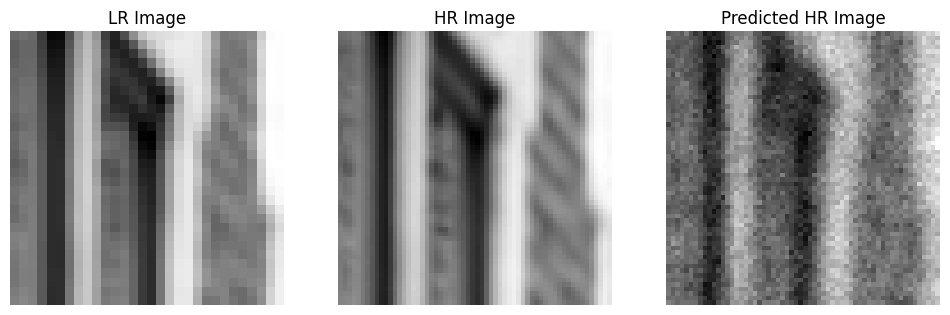

time: 165 ms (started: 2025-01-17 04:01:14 +07:00)


In [46]:
test = X_test[0]
test = test.reshape(1, test.shape[0], test.shape[1])

label = y_test[0]

pred = model.predict(test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(test[0], cmap='gray')
plt.title("LR Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(label, cmap='gray')
plt.title("HR Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred[0], cmap='gray')
plt.title("Predicted HR Image")
plt.axis('off')

plt.show()

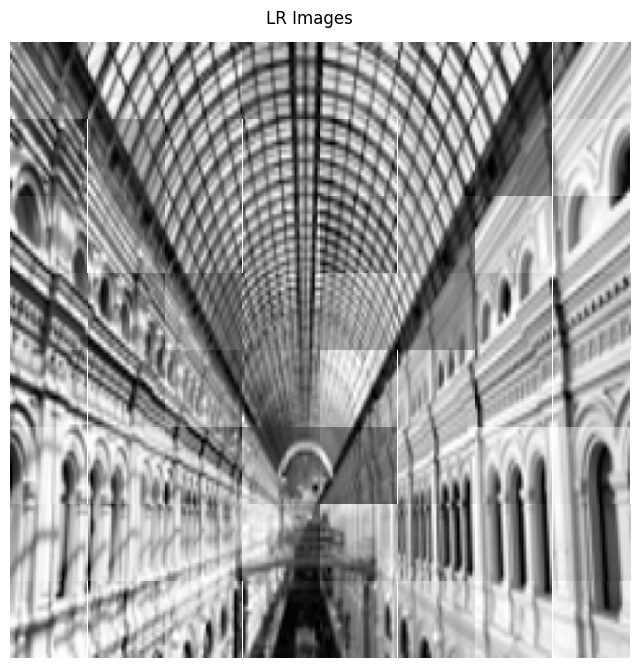

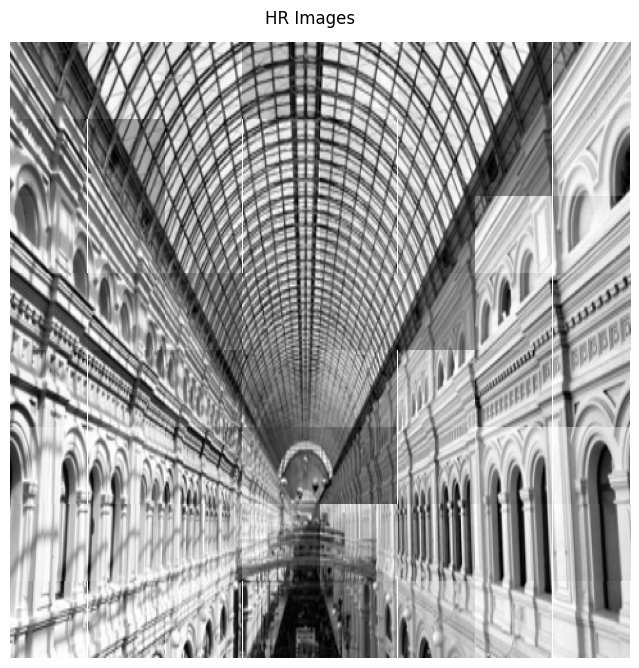

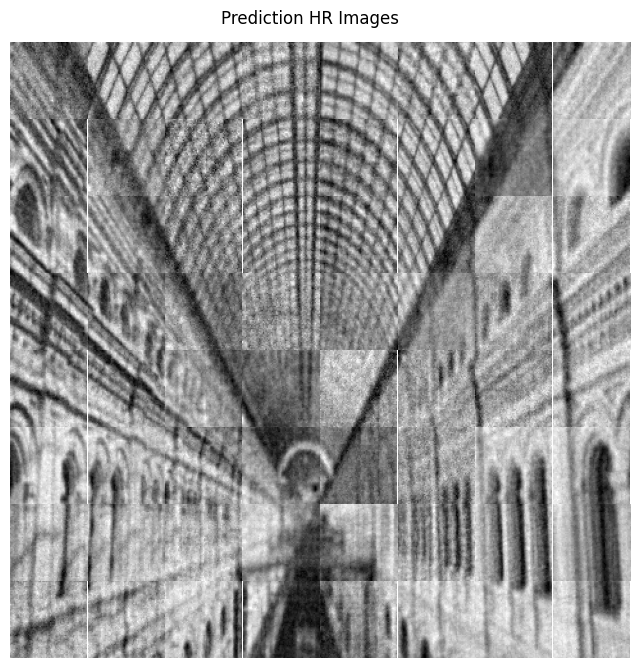

time: 2.03 s (started: 2025-01-15 20:29:15 +07:00)


In [18]:
input = lr_images[5120:5120+64]
output = hr_images[5120:5120+64]

pred = model.predict(input)

fig, axes = plt.subplots(8, 8, figsize=(8, 8), gridspec_kw={'wspace': 0, 'hspace': 0})
for i, ax in enumerate(axes.flat):
    ax.imshow(input[i], cmap='gray')
    ax.axis('off')
fig.suptitle("LR Images", y=0.92)
plt.show()

fig, axes = plt.subplots(8, 8, figsize=(8, 8), gridspec_kw={'wspace': 0, 'hspace': 0})
for i, ax in enumerate(axes.flat):
    ax.imshow(output[i], cmap='gray')
    ax.axis('off')
fig.suptitle("HR Images", y=0.92)
plt.show()

fig, axes = plt.subplots(8, 8, figsize=(8, 8), gridspec_kw={'wspace': 0, 'hspace': 0})
for i, ax in enumerate(axes.flat):
    ax.imshow(pred[i], cmap='gray')
    ax.axis('off')
fig.suptitle("Prediction HR Images", y=0.92)
plt.show()

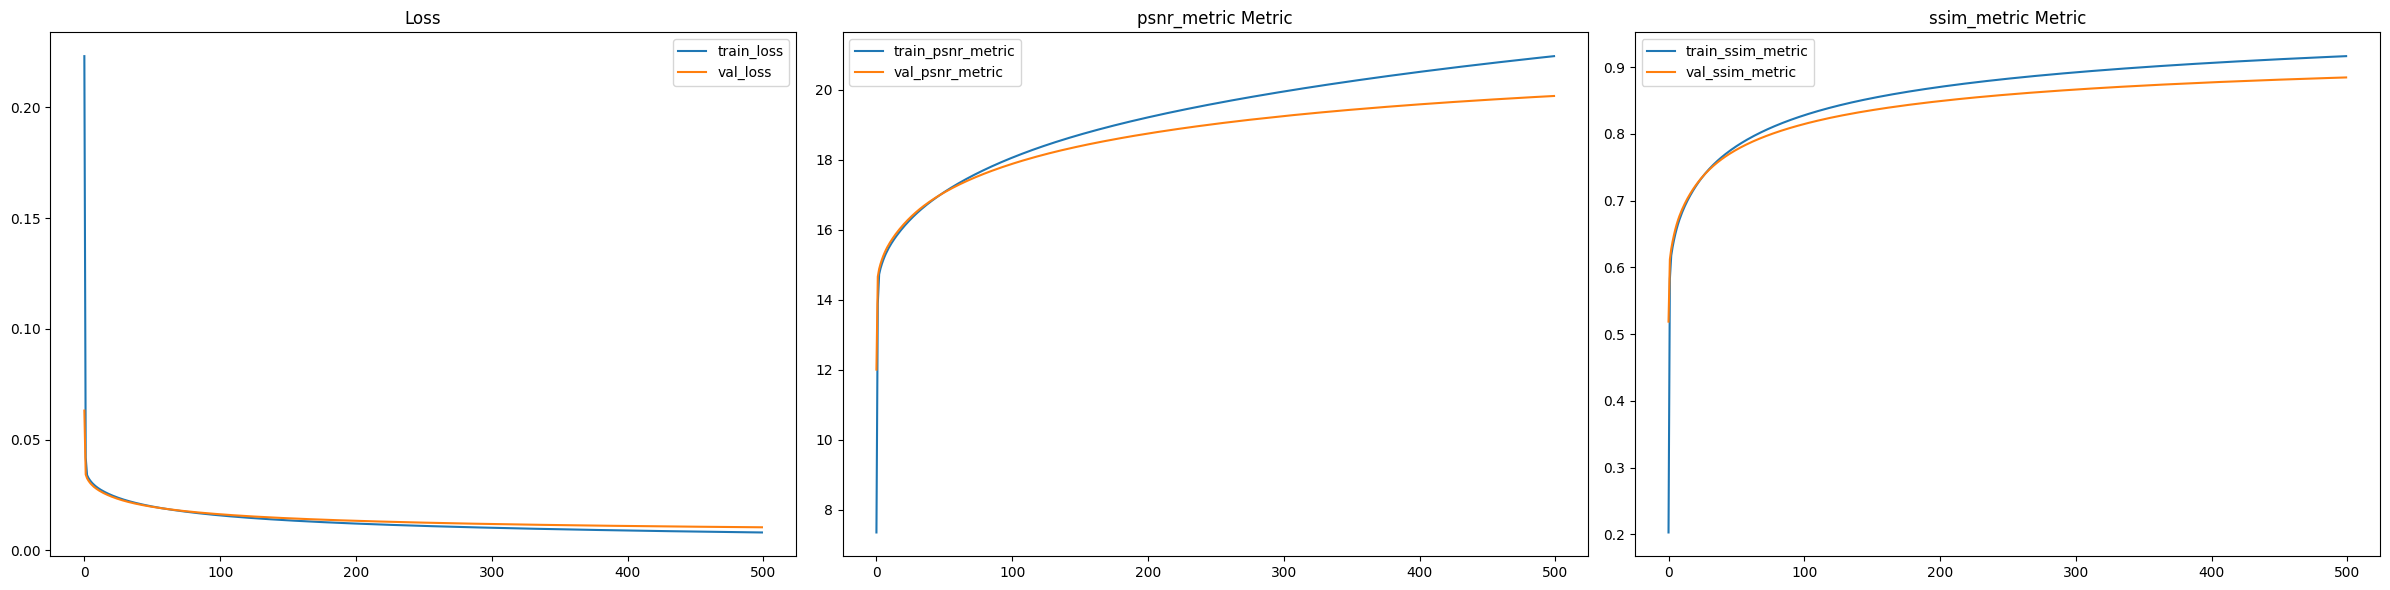

time: 259 ms (started: 2025-01-17 04:01:15 +07:00)


In [47]:
history = model.history

plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")

for i, metric in enumerate(history['train_metric']):
    plt.subplot(1, 3, i + 2)
    plt.plot(history['train_metric'][metric], label=f'train_{metric}')
    plt.plot(history['val_metric'][metric], label=f'val_{metric}')
    plt.title(f"{metric} Metric")
    plt.legend()
    
plt.tight_layout()
plt.show()